**Enoncé Projet 3** : Voici une vision globale des étapes techniques pour un premier moyen de transport (par exemple les bornes de vélos en libre-service) : Récupération par fichier plat des données unitaires et affichage d’une carte Collecte via une API des données unitaires et mise à jour de la carte Automatisation toutes les 15 minutes de la collecte via API et stockage de cet historique dans une base de données

Suivant l’heure du jour, vous verrez une sorte de “respiration”, en fonction des lieux de sorties, des quartiers de bureaux ou des zones résidentielles.

Puis, vous pourrez ajouter un second moyen de transport, etc...

Suivant les villes il y a des bornes de comptage sur les voies cyclables, et de trafic sur les voies rapides Concernant les transports en commun, vous obtiendrez la fréquence de desserte, mais vous n’avez généralement pas accès aux données sur la fréquentation (nombre d’usagers)

Pour automatiser la collecte, votre formateur vous donnera accès à une quête nommée “schedule”. Dans un process réel en entreprise, vous pourriez payer pour un serveur cloud. Ici, un ordinateur d’un membre du groupe pourra jouer le rôle de serveur, il faudra le faire tourner pendant minimum 48h pour avoir des résultats représentatifs.


###**Objectifs**
1. Automatiser la collecte de données afin de se constituer un historique de données (ex: connaître toutes les heures de passage des bus de la ligne 141 sur une journée, ou une période donnée)
2. Le faire d'abord pour un moyen de transport donné, puis étendre notre dataset en retenant d'autres moyens de transport
3. Visualiser par heure du jour via une map la densité du trafic

NB : Collecte toutes les 15min et pendant 48h (via library Schedule)

###**Outils / liens**
- Sujet projet -> https://docs.google.com/presentation/d/13m9KBTcyNWn0Bv6fEPkDp-HQaLsto65_/edit#slide=id.p12
- Trello -> https://trello.com/b/kNibrPGH/wcs-projet-3-transports-publics?completedInviteSignup=1
- Dashboard -> https://docs.google.com/spreadsheets/d/15u4nUEHV6tNLWb_1wRapEoc3HafNCN4fytNcaT5PSZg/edit?gid=352383392#gid=352383392
- Présentation Canva -> https://www.canva.com/design/DAGQ6fyaRf0/SmQXtXBCCdvfe561mOtEOQ/edit


###**Ressources**

- https://cartovista.com/fr/real-time-data-cartovista-api-python/ -> exemple
- https://appsource.microsoft.com/en-us/product/power-bi-visuals/wa104380981?tab=overview -> lien cartes dynamiques (cf Aïssata)
- https://medium.com/search?q=carte+interactive+avec+python+et+folium -> autre source pour cartes dynamiques

----------
- https://help.opendatasoft.com/apis/ods-explore-v2/#section/Introduction/Base-URL -> méthodologie requêtage API
- https://www.data.gouv.fr/fr/organizations/rennes-metropole-en-acces-libre-1/#/datasets -> comptage vélos et piétons ++ état du trafic en temps réel
- https://www.data.gouv.fr/fr/datasets/prochains-passages-des-lignes-de-bus-du-reseau-star-en-temps-reel/ -> fichiers csv avec passages bus temps réel
- https://data.explore.star.fr/explore/dataset/tco-bus-circulation-passages-tr/api/ -> datasource API pour requêter directement les données en temps réel des prochains passages des bus
- https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220001%22 -> API RENNES pour le "nomcourtligne": "C1"
- https://data.rennesmetropole.fr/explore/dataset/etat-du-trafic-en-temps-reel/api/?location=11,48.1001,-1.68285&basemap=0a029a -> datasource API pour requêter directement les données en temps réel du trafic routier tps réel
- https://data.rennesmetropole.fr/api/explore/v2.1/catalog/datasets/etat-du-trafic-en-temps-reel/records?limit=20 -> API RENNES trafic routier
- https://data.rennesmetropole.fr/explore/dataset/etat-du-trafic-en-temps-reel/information/ -> dictionnaire des données API trafic routier tps réel

# **PART.1 = COLLECTE DES DONNEES --> REQUÊTAGE API ET AUTOMATISATION + COMPILATION DES DONNEES HISTORIQUES**

In [ ]:
#LES LINKS APIS
# https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220001%22
# https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220002%22
# https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220003%22
# https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220004%22
# https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220005%22

In [ ]:
### ETAPE 0.a => FONCTION D'ENCODAGE POUR AUTOMATISER LA GENERATION DES URLS DES DIFFERENTES SOURCES API TRAFIC ROUTIER

import urllib.parse

def encode_url_elements(liste):
    # Créer une nouvelle liste pour stocker les éléments encodés
    encoded_list = []

    # Parcourir chaque élément de la liste
    for element in liste:
        # Encodage de l'élément pour qu'il soit utilisable dans une URL
        encoded_element = urllib.parse.quote(element)
        encoded_element += "%22"
        # Ajouter l'élément encodé à la liste
        encoded_list.append(encoded_element)

    return encoded_list

In [ ]:
### ETAPE 0.b => ON GENERE AUTOMATIQUEMENT LES URLS DES DIFFERENTES SOURCE API BUS ET METRO (TÂCHE A REALISER 1 FOIS)

# URL de base - data bus ---> rem. : Au lieu de limit=20 on change par limit=-1 pour récupérer l'exhaustivité des données disponibles dans l'API propre à chaque ligne (sinon 20 par défaut)
base_url_bus = "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%22"

# URL de base - data métro (API métro)
url_metro_a = "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-metro-circulation-passages-tr/records?limit=-1&refine=nomcourtligne%3A%22a%22"
url_metro_b = "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-metro-circulation-passages-tr/records?limit=-1&refine=nomcourtligne%3A%22b%22"

# URL de base - data trafic routier ---> rem. : Au lieu de limit=20 on change par limit=-1 pour récupérer l'exhaustivité des données disponibles dans l'API propre à chaque ligne (sinon 20 par défaut)
base_url_routier = "https://data.rennesmetropole.fr/api/explore/v2.1/catalog/datasets/etat-du-trafic-en-temps-reel/records?limit=-1&refine=denomination%3A%22"

# liste des dénominations possibles pour le réseau routier
list_denomination_routier = ["Rond-point","Route nationale 136","Route départementale 34","Route départementale 29","Rue de Rennes","Route nationale 24","Rue de Fougères","Avenue Général George S. Patton",
                     "Rue du Général de Gaulle","Boulevard des Alliés","Rue Jules Vallès","Rue de Vern","Avenue Henri Fréville","Rue de Saint-Malo","Rue de Châteaugiron","Boulevard de Verdun",
                     "Rue Nationale","Boulevard Villebois-Mareuil","Rue de Nantes","Rue de Montfort","Avenue Général Leclerc","Rue de Lorient","Route départementale 288","Route départementale 82",
                     "Boulevard de Vitré","Avenue de la Libération","Boulevard Eugène Pottier","Boulevard Jean Mermoz","Route départementale 837","Route départementale 463","Rue de Vezin","Rue des Loges",
                     "Avenue de Rochester","Route départementale 173","Avenue Professeur Charles Foulon","Boulevard Georges Clemenceau","Boulevard Léon Grimault","Boulevard de Metz","Rue de Saint-Brieuc",
                     "Rue du Clos Courtel","Avenue Charles et Raymonde Tillon","Avenue Roger Dodin","Boulevard Oscar Leroux","Porte d'Alma","Route départementale 175","Avenue des Pays-Bas",
                     "Boulevard Emile Combes","Boulevard Voltaire","Porte de Bréquigny","Rue Jean Guéhenno","Rue Louis Guilloux","Rue Vaneau","Rue André Léo","Boulevard Saint-Roch","Porte de Saint-Nazaire",
                     "Route de Fougères","Avenue des Buttes de Coësmes","Porte de Maurepas","Avenue Gros Malhon","Avenue des Préales","Porte de Brest","Route de Saint-Malo","Rue Claude Bernard",
                     "Rue d'Antrain","Boulevard Saint-Jean-Baptiste de la Salle","Porte de Lorient","Route nationale 137","Avenue de la Touraudais","Boulevard Bertrand d'Argentré","Boulevard de Strasbourg",
                     "Route départementale 177","Avenue François Château","Boulevard Léon Bourgeois","Boulevard Volney","Porte de Beaulieu","Porte de Villejean","Route nationale 12","Avenue Andrée Viollis",
                     "Avenue des Champs Bleus","Boulevard Pierre Mendès-France","Boulevard d'Armorique","Porte de Cleunay","Route nationale 1012","Rue de Brest","Avenue de Belle Fontaine","Franklin Roosevelt",
                     "Rue Malakoff","Voie communale 1","Boulevard de l'Yser","Inconnu Voie non dénommée","Porte d'Angers","Rond-point de Ker Lann","Rond-point de Vaux","Rond-point des Sorinais",
                     "Rond-point du Château des Marais","Rond-point du Pâtis Fraux","Route départementale 224","Mail François Mitterrand","Passage Henri Fréville","Porte de Tizé"]

# Encodage de la liste des dénominations du réseau routier grâce à fonction précédemment créée
encoded_list_denomination = encode_url_elements(list_denomination_routier)

# Liste pour stocker les URLs générées via l'API Metro
urls_metro = [url_metro_a, url_metro_b]

# Liste pour stocker les URLs générées via l'API BUS
urls_bus = []

# Liste pour stocker les URLs générées via l'API RESEAU ROUTIER
urls_routier = []

# Boucle pour générer les URLs BUS de 1 à 200   ////  PARAMETRE A MODIFIER SI BESOIN /!\
for i in range(1, 201):
    line_number = str(i).zfill(4)               # Formatage du numéro de ligne avec zéro(s) devant
    url = f"{base_url_bus}{line_number}%22"     # Construire l'URL complète
    urls_bus.append(url)                        # Ajouter l'URL à la liste des urls bus soit la liste 'urls_bus'

# Boucle pour générer les URLs du réseau routier //// PARAMETRE A MODIFIER SI BESOIN /!\
for elt in encoded_list_denomination:
    url = f"{base_url_routier}{elt}"            # Construire l'URL complète
    urls_routier.append(url)                    # Ajouter l'URL à la liste

# Affichage des URLs bus - métro - routier générées
for url in urls_bus:
    print(url)

for url in urls_metro:
  print(url)

for url in urls_routier:
    print(url)

print(f"nombre d'url total API BUS: {len(urls_bus)}")
print(f"nombre d'url total API METRO: {len(urls_metro)}")
print(f"nombre d'url total API réseau routier: {len(urls_routier)}")


https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220001%22
https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220002%22
https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220003%22
https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220004%22
https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220005%22
https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220006%22
https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=-1&refine=idligne%3A%220007%22
https://data.explore

In [ ]:
### ETAPE 1 => FONCTION DE REQUÊTAGE POUR UN LIEN API (SOIT POUR UNE SEULE LIGNE DE BUS, METRO OU AUTRE MOYEN DE TRANSPORT)

import requests
import pandas as pd

# # List of API endpoints
# urls = [
#     "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220001%22",
#     "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220002%22",
#     "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220003%22",
#     "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220004%22",
#     "https://data.explore.star.fr/api/explore/v2.1/catalog/datasets/tco-bus-circulation-passages-tr/records?limit=20&refine=idligne%3A%220005%22"
# ]

## Fonction qui récupère et traite les données API pour une ligne de bus, métro, et tout autre moyen de transport (/!\ format structure Json à éventuellement ajuster !!)
## => Démarche = requêtage données format json et implémentation dans une liste processed_data + définition de la structure générale du dictionnaire imbriqué + conversion de la liste finale en dataframe

def fetch_and_process_data(url):
    response = requests.get(url).json()
    data = response['results']
    # Process data (e.g., extract relevant fields)
    processed_data = []
    for entry in data:
        processed_entry = {
            'idligne': entry.get('idligne') if entry.get('idligne') else entry.get('gml_id'), ## l’identifiant du tronçon Rennes Métropole auquel l’information est rattachée. L’identifiant peut être suffixé par « _D » et « _G » dans le cas de tronçon à double sens de circulation. Le sens de numérisation du tronçon est alors le sens « D », le sens inverse le sens « G »
            'nomcourtligne': entry.get('nomcourtligne') if entry.get('nomcourtligne') else entry.get('denomination'),
            'sens': entry.get('sens'),
            'destination': entry.get('destination') if entry.get('destination') else entry.get('predefinedlocationreference'),
            'idarret': entry.get('idarret'),
            'nomarret': entry.get('nomarret'),
            'lon': entry['coordonnees'].get('lon') if 'coordonnees' in entry else entry['geo_point_2d'].get('lon') if 'geo_point_2d' in entry else None,
            'lat': entry['coordonnees'].get('lat') if 'coordonnees' in entry else entry['geo_point_2d'].get('lat') if 'geo_point_2d' in entry else None,
            'arriveetheorique': entry.get('arriveetheorique'),
            'departtheorique': entry.get('departtheorique'),
            'arrivee': entry.get('arrivee'),
            'depart': entry.get('depart'),
            'idcourse': entry.get('idcourse'),
            'precision': entry.get('precision'),
            'visibilite': entry.get('visibilite'),
            'heureextraction': entry.get('heureextraction') if entry.get('heureextraction') else entry.get('datetime'),
            'trafficstatus': entry.get('trafficstatus'),
            'averagevehiclespeed': entry.get('averagevehiclespeed'),
            'vitesse_maxi': entry.get('vitesse_maxi')
        }
        processed_data.append(processed_entry)
    return pd.DataFrame(processed_data)


In [ ]:
### ETAPE 2 => FONCTION DE CONCATENATION DES DONNEES APRES REQUÊTAGE DES DIFFERENTES URLS (SOIT DE L'ENSEMBLE DES LIGNES DE BUS)
### Démarche => on appelle la fonction 'fetch_and_process_data' précédemment créée en étape 1 pour chaque urls disponible et générée en étape 0

def fetch_and_concat_data(urls):
    """
    Récupère les données à partir de plusieurs URLs, les concatène et retourne un DataFrame unique.

    :param urls: Liste d'URLs à requêter
    :return: DataFrame combiné
    """
    # Initialiser une liste pour stocker les DataFrames
    dataframes = []

    # Boucle sur les URLs pour récupérer et traiter les données
    for i, url in enumerate(urls):
        try:
            # Récupérer et traiter les données de chaque URL via la fonction fetch_and_process_data créée à l'étape 1
            df = fetch_and_process_data(url)
            dataframes.append(df)
        except Exception as e:
            print(f"Erreur lors de la requête pour l'URL {url}: {e}")

    # Concaténer tous les DataFrames dans un DataFrame unique
    combined_df = pd.concat(dataframes, ignore_index=True)

    return combined_df

In [ ]:
### ETAPE 3 => FONCTION DE SAUVEGARDE DE TTES LES DONNEES PRECEDEMMENT REQUÊTEES DANS UN FICHIER .CSV OU .TXT POUR CONSTITUER UN HISTORIQUE DE DONNEES (obj : 48h de données requêtées toutes les 15min)
### Démarche => on génère un horodatage qu'on implémente dans le nom du fichier .csv de requêtage et stockage, en prévision du stockage répété pendant 48h pour distinguer l'ensemble des fichiers .csv
### /!\ FONCTIONNE EN LOCAL UNIQUEMENT AUTREMENT DIT SUR JUPYTER NOTEBOOK

from datetime import datetime

def save_dataframe_with_timestamp(df, file_format='csv', transport='bus'): ## où df est le dataframe à sauvegarder et file_format='csv' le format du fichier de sortie généré // format .txt possible

    # Générer un horodatage sous forme de string
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format YYYYMMDD_HHMMSS

    # Nom du fichier avec horodatage
    file_name = f"{transport}_data_{timestamp}" ## où le moyen de transport est à la main de l'utilisateur (paramètre fonction) et intégré au nom du fichier avec la date

    if file_format == 'csv':
        df.to_csv(f"{file_name}.csv", index=False, sep=',', encoding='utf-8')
        print(f"DataFrame sauvegardé en fichier {file_name}.csv")

    elif file_format == 'txt':
        df.to_csv(f"{file_name}.txt", index=False, sep='\t', encoding='utf-8')
        print(f"DataFrame sauvegardé en fichier {file_name}.txt")

    else:
        print(f"Format non supporté : {file_format}. Utilisez 'csv' ou 'txt'.")

# ## Test bon fonctionnement fonction
# save_dataframe_with_timestamp(combined_df, 'csv', 'bus')  # Sauvegarder en CSV avec horodatage + flag 'bus' dans le nom du fichier


In [ ]:
### ETAPE 4 => ON TESTE L'ENCHAÎNEMENT DES FONCTIONS DES ETAPES 0,1,2,3 AVANT DE POUVOIR METTRE EN OEUVRE SCHEDULE POUR LA REPETITION DES TÂCHES 1,2,3 A INSTANT DONNE (OBJ : TOUTES LES 15 MIN PDT 48H)

import os
print(os.getcwd()) ## permet d'afficher le répertoire de travail en local où seront stockés les fichiers de sortie (données requêtées)

# df_test = fetch_and_process_data(url) ## exécution ETAPE 1 à partir de url de départ
df_combined_bus_test = fetch_and_concat_data(urls_bus) ## exécution ETAPE 2 à partir de l'ensemble des urls générées en ETAPE 0
df_combined_metro_test = fetch_and_concat_data(urls_metro) ## exécution ETAPE 2 à partir de l'ensemble des urls générées en ETAPE 0
df_combined_routier_test = fetch_and_concat_data(urls_routier) ## exécution ETAPE 2 à partir de l'ensemble des urls générées en ETAPE 0
# print(f"taille df_test: {len(df_test)}") ## à supp car pas très utile puisque donne l'info pour le dernier df dispo (i.e. dernière ligne de bus requêtée)
print(f"taille df_combined_bus_test: {len(df_combined_bus_test)}") ## permet d'indiquer la taille du df consolidé
print(f"taille df_combined_metro_test: {len(df_combined_metro_test)}") ## permet d'indiquer la taille du df consolidé
print(f"taille df_combined_routier_test: {len(df_combined_metro_test)}") ## permet d'indiquer la taille du df consolidé
# display(df_combined_test.head())
# print(df_combined_test["nomcourtligne"].unique()) ## permet de lister toutes les lignes de bus requêtées

## créer un dictionnaire avec toutes les lignes de bus requêtées et le nombre de données collectées pour chaque :
rslt_bus_dict = dict(df_combined_bus_test["nomcourtligne"].value_counts())
print(f"Nombre de données collectées par ligne de bus : {rslt_bus_dict}")
print(f"Nombre de lignes de bus collectées : {len(rslt_bus_dict)}")
# display(df_combined_test["nomcourtligne"].value_counts()) ## permet d'indiquer le volume de données requêtées pour chaque ligne de bus
save_dataframe_with_timestamp(df_combined_bus_test, 'csv', 'bus') ## permet de sauvegarder les données précédemment requêtées

## créer un dictionnaire avec toutes les lignes de metro requêtées et le nombre de données collectées pour chaque :
rslt_metro_dict = dict(df_combined_metro_test["nomcourtligne"].value_counts())
print(f"\nNombre de données collectées par ligne de metro : {rslt_metro_dict}")
print(f"Nombre de lignes de metro collectées : {len(rslt_metro_dict)}")
# display(df_combined_test["nomcourtligne"].value_counts()) ## permet d'indiquer le volume de données requêtées pour chaque ligne de bus
save_dataframe_with_timestamp(df_combined_metro_test, 'csv', 'metro') ## permet de sauvegarder les données précédemment requêtées

## créer un dictionnaire avec tout le réseau routier requêté et le nombre de données collectées pour chaque :
rslt_routier_dict = dict(df_combined_routier_test["nomcourtligne"].value_counts())
print(f"\nNombre de données collectées par réseau routier : {rslt_routier_dict}")
print(f"Nombre de réseau routier collecté : {len(rslt_routier_dict)}")
# display(df_combined_test["nomcourtligne"].value_counts()) ## permet d'indiquer le volume de données requêtées pour chaque ligne de bus
save_dataframe_with_timestamp(df_combined_routier_test, 'csv', 'routier') ## permet de sauvegarder les données précédemment requêtées


In [ ]:
### ETAPE 5 => IMPORT DE LA LIBRAIRIE SCHEDULE POUR AUTOMATISER LA REPETITION PERIODIQUE DES TÂCHES 1,2,3 (OBJ = TOUTES LES 15 MIN PDT 48H)
### Démarche => on créée une fonction 'job' qui enchaine les 3 fonctions précédemment créées en Etapes 1,2,3 et qu'on appelle via schedule toutes les 15 min pour répétition du requêtage et stockage en .csv

!pip install schedule
import schedule
import time

def job():
    """
    Fonction de tâche à exécuter toutes les 15 minutes.
    """
    # df = fetch_and_process_data(url)
    df_combined_bus = fetch_and_concat_data(urls_bus)
    df_combined_metro = fetch_and_concat_data(urls_metro)
    df_combined_routier = fetch_and_concat_data(urls_routier)
    save_dataframe_with_timestamp(df_combined_bus, 'csv', 'bus')
    save_dataframe_with_timestamp(df_combined_metro, 'csv', 'metro')
    save_dataframe_with_timestamp(df_combined_routier, 'csv', 'routier')

# Planifier la tâche toutes les 15 minutes
schedule.every(15).minutes.do(job)

# Boucle infinie pour exécuter le scheduler
while True:
    schedule.run_pending()
    time.sleep(1)  # Pause de 1 seconde avant de vérifier la prochaine tâche


In [ ]:
### ETAPE 6 => COMPILATION DES DONNEES STOCKEES DANS FICHIERS .CSV GENERES AUX ETAPES PRECEDENTES (REQUETAGE API) DANS DATAFRAME df_combined + AJOUT COLONNE AVEC HEURE/DATE EXTRACTION API + SAUVEGARDE DF FORMAT .CSV
### /!\ Avant de compiler les données, penser à homogénéiser les noms des 3 fichiers csv metro-bus-routier qd il y a des différence de datetime (même date - heure)
### /!\ Penser à mettre à jour le path de stockage des fichiers .csv requêté précédemment dans dossier spécifique sur le drive perso
import os
import pandas as pd
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Chemin où se trouvent tous les fichiers .csv de requêtage de l'API ----- /!\ PATH A METTRE A JOUR !!!!!!!
directory_path = '/content/drive/My Drive/fichiers_metro_Bus_Routier/'

# Lister tous les fichiers dans le répertoire et filtrer uniquement sur les fichiers avec extension .csv
all_files = os.listdir(directory_path)
csv_files = [f for f in all_files if f.endswith('.csv')]

# Initialiser un dictionnaire pour stocker les DataFrames par transport
transport_dataframes = {'bus': [], 'metro': [], 'routier': []}

# Lire chaque fichier .csv, ajouter les colonnes et l'ajouter à la liste des DataFrames du bon transport
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)

    # Extraire la date, l'heure et le transport à partir du nom du fichier
    if len(file.split('_')) == 4:
        # Exemple de nom de fichier : bus_data_20240913_015206.csv
        timestamp = file.split('_')[3].replace('.csv', '')  # '015206'
        datestamp = file.split('_')[2]  # '20240913'
        transport = file.split('_')[0]  # 'bus', 'metro', 'routier'

        # Formater la date et l'heure
        date = f"{datestamp[:4]}-{datestamp[4:6]}-{datestamp[6:]}"
        time = f"{timestamp[:2]}:{timestamp[2:4]}:{timestamp[4:]}"
        date_time_str = f"{date} {time}"

        # Convertir en format datetime64[ns, UTC]
        date_time_api = pd.to_datetime(date_time_str, format='%Y-%m-%d %H:%M:%S', utc=True)

        # Ajouter les colonnes 'date_heure_requete_API' et 'transport_API'
        df['date_heure_requete_API'] = date_time_api
        df['transport_API'] = transport

        # Ajouter le DataFrame dans la liste correspondant au type de transport
        if transport in transport_dataframes:
            transport_dataframes[transport].append(df)

        # Afficher un message pour chaque fichier
        print(f"Fichier {file} chargé avec {len(df)} lignes ====> colonne date_heure_requete_API = {date_time_api}")

# Traiter chaque type de transport
for transport, df_list in transport_dataframes.items():
    if df_list:
        # Concaténer tous les fichiers du même type de transport
        df_combined = pd.concat(df_list, ignore_index=True)

        # Utiliser la date du dernier fichier pour le nom final
        date_file = df_combined['date_heure_requete_API'].max().strftime('%Y%m%d')

        # Enregistrer le DataFrame combiné au format CSV
        output_csv_path = f'/content/drive/My Drive/Projet3/df_combined_{transport}_{date_file}.csv'
        df_combined.to_csv(output_csv_path, index=False)

        # Afficher le nombre de fichiers concaténés et de lignes du DataFrame combiné
        print(f"\nNombre total de fichiers CSV chargés pour '{transport}' : {len(df_list)}")
        print(f"Nombre total de lignes du dataframe '{transport}' combiné : {len(df_combined)}")
        print(f"DataFrame '{transport}' combiné sauvegardé dans: {output_csv_path}")


# **PART.2 = TRAITEMENT DES DONNEES --> CHARGEMENT + EXPLORATION + NETTOYAGE**

In [ ]:
### ETAPE 1 => CHARGEMENT DES DONNEES // ** To KEEP **
# Lire le fichier / import des données [suppose d'enrgistrer le/les fichiers .csv dans le drive perso de chacune directement à la racine]
### /!\ PATH A METTRE A JOUR !!

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df_bus = pd.read_csv("/content/drive/My Drive/Projet3/df_combined_bus_20240925.csv") ################## /!\ à mettre à jour
df_metro = pd.read_csv("/content/drive/My Drive/Projet3/df_combined_metro_20240925.csv") ############## /!\ à mettre à jour
df_routier = pd.read_csv("/content/drive/My Drive/Projet3/df_combined_routier_20240925.csv") ########## /!\ à mettre à jour

print(f"taille df_bus:     {len(df_bus)}")
print(f"taille df_metro:   {len(df_metro)}")
print(f"taille df_routier: {len(df_routier)}")

Mounted at /content/drive
taille df_bus:     290673
taille df_metro:   16970
taille df_routier: 231992


In [ ]:
### EXPLORATION DES DONNEES POUR CHECK et MIEUX COMPRENDRE LE CONTENU DU DATAFRAME ET LA FAISABILITE DES KPI
##  CHECK => Bonne exécution de la compilation + création + typage colonne -> df_bus
## concl = colonnes bien créées mais format 'date_heure_requete_API' non correcte donc à convertir avec les autres colonne date/heure (arrivee, depart, arriveeth, etc)

df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290673 entries, 0 to 290672
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 290673 non-null  int64  
 1   nomcourtligne           290673 non-null  object 
 2   sens                    290673 non-null  int64  
 3   destination             289749 non-null  object 
 4   idarret                 290673 non-null  int64  
 5   nomarret                290673 non-null  object 
 6   lon                     290673 non-null  float64
 7   lat                     290673 non-null  float64
 8   arriveetheorique        290673 non-null  object 
 9   departtheorique         290673 non-null  object 
 10  arrivee                 290673 non-null  object 
 11  depart                  290673 non-null  object 
 12  idcourse                290673 non-null  int64  
 13  precision               290673 non-null  object 
 14  visibilite          

In [ ]:
### CHECK => Bonne exécution de la compilation + création colonne -> df_metro
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16970 entries, 0 to 16969
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   idligne                 16970 non-null  int64  
 1   nomcourtligne           16970 non-null  object 
 2   sens                    16970 non-null  int64  
 3   destination             16970 non-null  object 
 4   idarret                 16970 non-null  int64  
 5   nomarret                16970 non-null  object 
 6   lon                     16970 non-null  float64
 7   lat                     16970 non-null  float64
 8   arriveetheorique        0 non-null      float64
 9   departtheorique         0 non-null      float64
 10  arrivee                 15241 non-null  object 
 11  depart                  12775 non-null  object 
 12  idcourse                0 non-null      float64
 13  precision               16970 non-null  object 
 14  visibilite              0 non-null    

In [ ]:
### CHECK => Bonne exécution de la compilation + création colonne -> df_routier
df_routier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231992 entries, 0 to 231991
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 231992 non-null  object 
 1   nomcourtligne           231992 non-null  object 
 2   sens                    0 non-null       float64
 3   destination             231992 non-null  object 
 4   idarret                 0 non-null       float64
 5   nomarret                0 non-null       float64
 6   lon                     231992 non-null  float64
 7   lat                     231992 non-null  float64
 8   arriveetheorique        0 non-null       float64
 9   departtheorique         0 non-null       float64
 10  arrivee                 0 non-null       float64
 11  depart                  0 non-null       float64
 12  idcourse                0 non-null       float64
 13  precision               0 non-null       float64
 14  visibilite          

In [ ]:
### CHECK BUS => unicité des valeurs des colonnes du df
print(f"Nombre de 'idligne' unique: {df_bus.idligne.nunique()}")
print(f"Nombre de 'nomcourtligne' unique: {df_bus.nomcourtligne.nunique()}")
print(f"Nombre de 'destination' unique: {df_bus.destination.nunique()}")
print(f"Nombre de 'idarret' unique: {df_bus.idarret.nunique()}")
print(f"Nombre de 'nomarret' unique: {df_bus.nomarret.nunique()}")
print(f"Nombre de coordonnées 'lon' unique: {df_bus.lon.nunique()}")
print(f"Nombre de coordonnées 'lat' unique: {df_bus.lat.nunique()}")
print(f"Nombre de 'idcourse' unique: {df_bus.idcourse.nunique()}")
print(f"Nombre de 'date_heure_requete_API' unique: {df_bus.date_heure_requete_API.nunique()}")
print(f"Nombre de 'heureextraction' unique: {df_bus.heureextraction.nunique()}")
print(f"Nombre de 'transport_API' unique: {df_bus.transport_API.nunique()} ---> {df_bus.transport_API.unique()}")
print(f"Depart min:            {df_bus.depart.min()} // Depart max:            {df_bus.depart.max()}")
print(f"Arrivee min:           {df_bus.arrivee.min()} // Arrivee max:           {df_bus.arrivee.max()}")
print(f"Arrivee theorique min: {df_bus.arriveetheorique.min()} // Arrivee theorique max: {df_bus.arriveetheorique.max()}")

Nombre de 'idligne' unique: 64
Nombre de 'nomcourtligne' unique: 64
Nombre de 'destination' unique: 90
Nombre de 'idarret' unique: 1427
Nombre de 'nomarret' unique: 682
Nombre de coordonnées 'lon' unique: 1424
Nombre de coordonnées 'lat' unique: 1418
Nombre de 'idcourse' unique: 3345
Nombre de 'date_heure_requete_API' unique: 94
Nombre de 'heureextraction' unique: 188
Nombre de 'transport_API' unique: 1 ---> ['bus']
Depart min:            2024-09-24T17:04:15+00:00 // Depart max:            2024-09-25T23:18:00+00:00
Arrivee min:           2024-09-24T16:46:51+00:00 // Arrivee max:           2024-09-26T21:58:00+00:00
Arrivee theorique min: 2024-09-23T22:00:00+00:00 // Arrivee theorique max: 2024-09-26T21:58:00+00:00


In [ ]:
### CHECK BUS => Bonne exécution de la compilation + création colonne
nb_occur_csv_bus = df_bus['date_heure_requete_API'].value_counts()
sorted_value_counts_bus = nb_occur_csv_bus.sort_index(ascending=True) # Convertir l'index de value_counts (les dates) en datetime si nécessaire, puis trier par ordre chronologique
display(sorted_value_counts_bus) # Afficher le résultat trié par ordre chronologique

date_heure_requete_API
2024-09-24 19:08:38+00:00    3908
2024-09-24 19:26:16+00:00    3648
2024-09-24 19:43:56+00:00    3431
2024-09-24 20:01:34+00:00    3171
2024-09-24 20:19:04+00:00    2927
                             ... 
2024-09-25 21:11:52+00:00    1742
2024-09-25 21:29:12+00:00    1387
2024-09-25 21:48:03+00:00    1255
2024-09-25 22:05:26+00:00    1092
2024-09-25 22:22:52+00:00     962
Name: count, Length: 94, dtype: int64

In [ ]:
### CHECK METRO => unicité des valeurs des colonnes du df
print(f"Nombre de 'idligne' unique: {df_metro.idligne.nunique()}")
print(f"Nombre de 'nomcourtligne' unique: {df_metro.nomcourtligne.nunique()}")
print(f"Nombre de 'destination' unique: {df_metro.destination.nunique()}")
print(f"Nombre de 'idarret' unique: {df_metro.idarret.nunique()}")
print(f"Nombre de 'nomarret' unique: {df_metro.nomarret.nunique()}")
print(f"Nombre de coordonnées 'lon' unique: {df_metro.lon.nunique()}")
print(f"Nombre de coordonnées 'lat' unique: {df_metro.lat.nunique()}")
print(f"Nombre de 'idcourse' unique: {df_metro.idcourse.nunique()}")
print(f"Nombre de 'date_heure_requete_API' unique: {df_metro.date_heure_requete_API.nunique()}")
print(f"Nombre de 'heureextraction' unique: {df_metro.heureextraction.nunique()}")
print(f"Nombre de 'transport_API' unique: {df_metro.transport_API.nunique()} ---> {df_metro.transport_API.unique()}")


Nombre de 'idligne' unique: 2
Nombre de 'nomcourtligne' unique: 2
Nombre de 'destination' unique: 4
Nombre de 'idarret' unique: 58
Nombre de 'nomarret' unique: 28
Nombre de coordonnées 'lon' unique: 58
Nombre de coordonnées 'lat' unique: 58
Nombre de 'idcourse' unique: 0
Nombre de 'date_heure_requete_API' unique: 94
Nombre de 'heureextraction' unique: 0
Nombre de 'transport_API' unique: 1 ---> ['metro']


In [ ]:
### CHECK METRO => Bonne exécution de la compilation + création colonne
nb_occur_csv_metro = df_metro['date_heure_requete_API'].value_counts()
sorted_value_counts_metro = nb_occur_csv_metro.sort_index(ascending=True) # Convertir l'index de value_counts (les dates) en datetime si nécessaire, puis trier par ordre chronologique
display(sorted_value_counts_metro) # Afficher le résultat trié par ordre chronologique

date_heure_requete_API
2024-09-24 19:08:38+00:00    200
2024-09-24 19:26:16+00:00    200
2024-09-24 19:43:56+00:00    200
2024-09-24 20:01:34+00:00    200
2024-09-24 20:19:04+00:00    200
                            ... 
2024-09-25 21:11:52+00:00    200
2024-09-25 21:29:12+00:00    200
2024-09-25 21:48:03+00:00    200
2024-09-25 22:05:26+00:00    200
2024-09-25 22:22:52+00:00    200
Name: count, Length: 94, dtype: int64

In [ ]:
### CHECK ROUTIER => unicité des valeurs des colonnes du df
print(f"Nombre de 'idligne' unique: {df_routier.idligne.nunique()}")
print(f"Nombre de 'nomcourtligne' unique: {df_routier.nomcourtligne.nunique()}")
print(f"Nombre de 'destination' unique: {df_routier.destination.nunique()}")
print(f"Nombre de coordonnées 'lon' unique: {df_routier.lon.nunique()}")
print(f"Nombre de coordonnées 'lat' unique: {df_routier.lat.nunique()}")
print(f"Nombre de 'idcourse' unique: {df_routier.idcourse.nunique()}")
print(f"Nombre de 'date_heure_requete_API' unique: {df_routier.date_heure_requete_API.nunique()}")
print(f"Nombre de 'heureextraction' unique: {df_routier.heureextraction.nunique()}")
print(f"Nombre de 'trafficstatus' unique: {df_routier.trafficstatus.nunique()} ---> {list(df_routier.trafficstatus.unique())}")
print(f"Nombre de 'averagevehiclespeed' unique: {df_routier.averagevehiclespeed.nunique()} ---> min:{df_routier.averagevehiclespeed.min()} // max:{df_routier.averagevehiclespeed.max()}")
print(f"Nombre de 'vitesse_maxi' unique: {df_routier.vitesse_maxi.nunique()} ---> min:{df_routier.vitesse_maxi.min()} // max:{df_routier.vitesse_maxi.max()}")
print(f"Nombre de 'transport_API' unique: {df_routier.transport_API.nunique()} ---> {df_routier.transport_API.unique()}")

Nombre de 'idligne' unique: 2468
Nombre de 'nomcourtligne' unique: 99
Nombre de 'destination' unique: 2468
Nombre de coordonnées 'lon' unique: 2468
Nombre de coordonnées 'lat' unique: 2468
Nombre de 'idcourse' unique: 0
Nombre de 'date_heure_requete_API' unique: 94
Nombre de 'heureextraction' unique: 171
Nombre de 'trafficstatus' unique: 4 ---> ['freeFlow', 'heavy', 'congested', 'unknown']
Nombre de 'averagevehiclespeed' unique: 131 ---> min:0 // max:130
Nombre de 'vitesse_maxi' unique: 6 ---> min:30 // max:110
Nombre de 'transport_API' unique: 1 ---> ['routier']


In [ ]:
### Zoom densité traffic =>
print(df_routier.trafficstatus.value_counts())
df_routier.groupby(by='date_heure_requete_API').trafficstatus.value_counts()

trafficstatus
unknown      93586
freeFlow     87585
heavy        43367
congested     7454
Name: count, dtype: int64


date_heure_requete_API     trafficstatus
2024-09-24 19:08:38+00:00  freeFlow         1230
                           heavy             640
                           unknown           482
                           congested         116
2024-09-24 19:26:16+00:00  freeFlow         1221
                                            ... 
2024-09-25 22:05:26+00:00  congested          23
2024-09-25 22:22:53+00:00  unknown          1443
                           freeFlow          781
                           heavy             209
                           congested          35
Name: count, Length: 376, dtype: int64

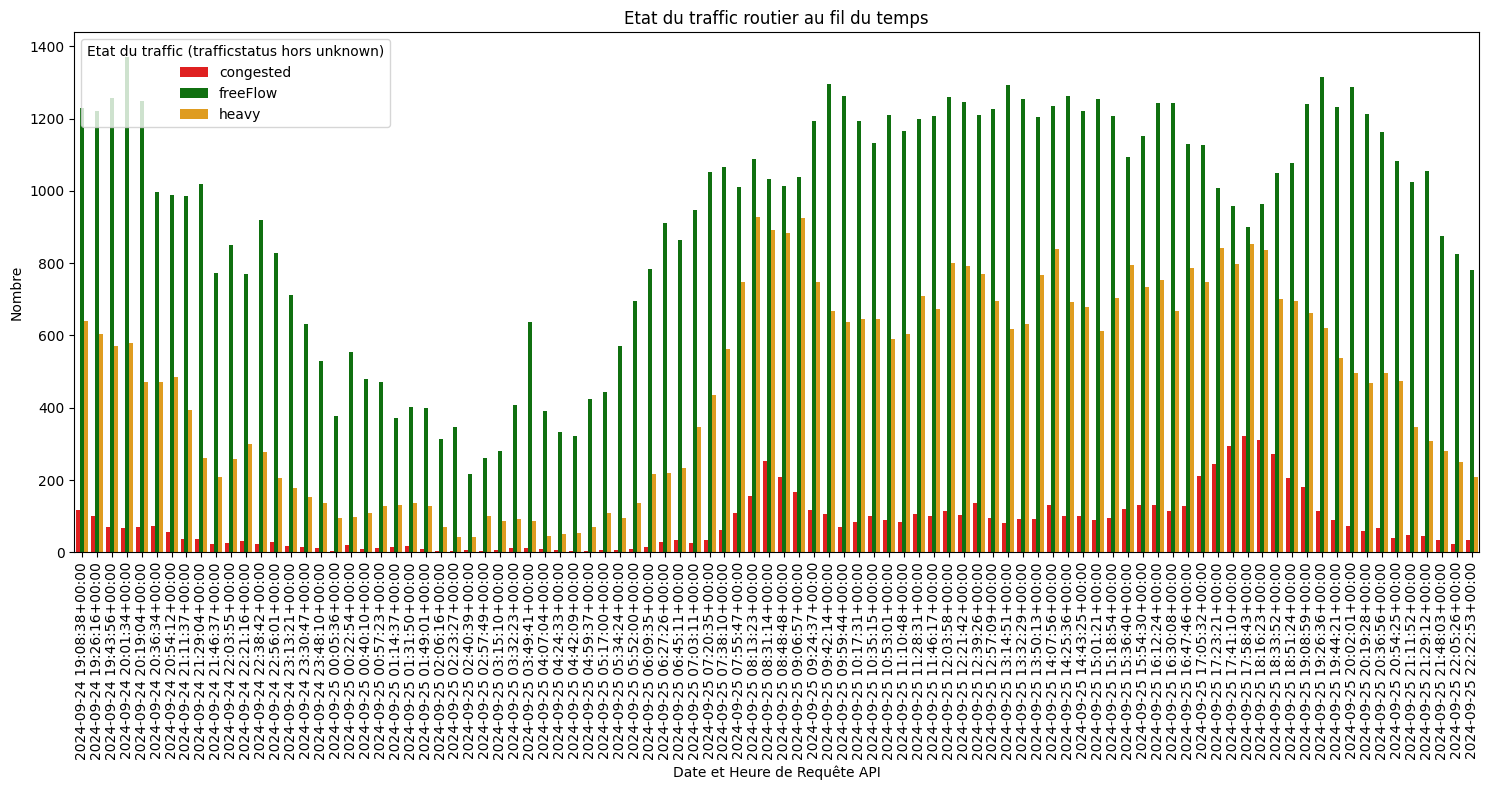

In [ ]:
# Histogramme en barre pour afficher l'état du traffic routier au fil des heures // pourrait être intéressant de faire des zoom en fonction du lieu

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrer le DataFrame pour exclure la catégorie 'unknown' dans 'trafficstatus'
df_filtered = df_routier[df_routier['trafficstatus'] != 'unknown']

# Regrouper par 'date_heure_requete_API' et 'trafficstatus', puis compter les occurrences
df_count = df_filtered.groupby(['date_heure_requete_API', 'trafficstatus']).size().reset_index(name='count')

# Créer un dictionnaire pour les couleurs personnalisées
palette = {'freeFlow': 'green', 'heavy': 'orange', 'congested': 'red'}

# Créer le graphique en barres avec Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='date_heure_requete_API', y='count', hue='trafficstatus', data=df_count, palette=palette)

# Ajuster l'affichage
plt.title('Etat du traffic routier au fil du temps')
plt.xlabel('Date et Heure de Requête API')
plt.ylabel('Nombre')
plt.xticks(rotation=90)  # Rotation des étiquettes en abscisse pour améliorer la lisibilité
plt.legend(title='Etat du traffic (trafficstatus hors unknown)')

# Afficher le graphique
plt.tight_layout()
plt.show()


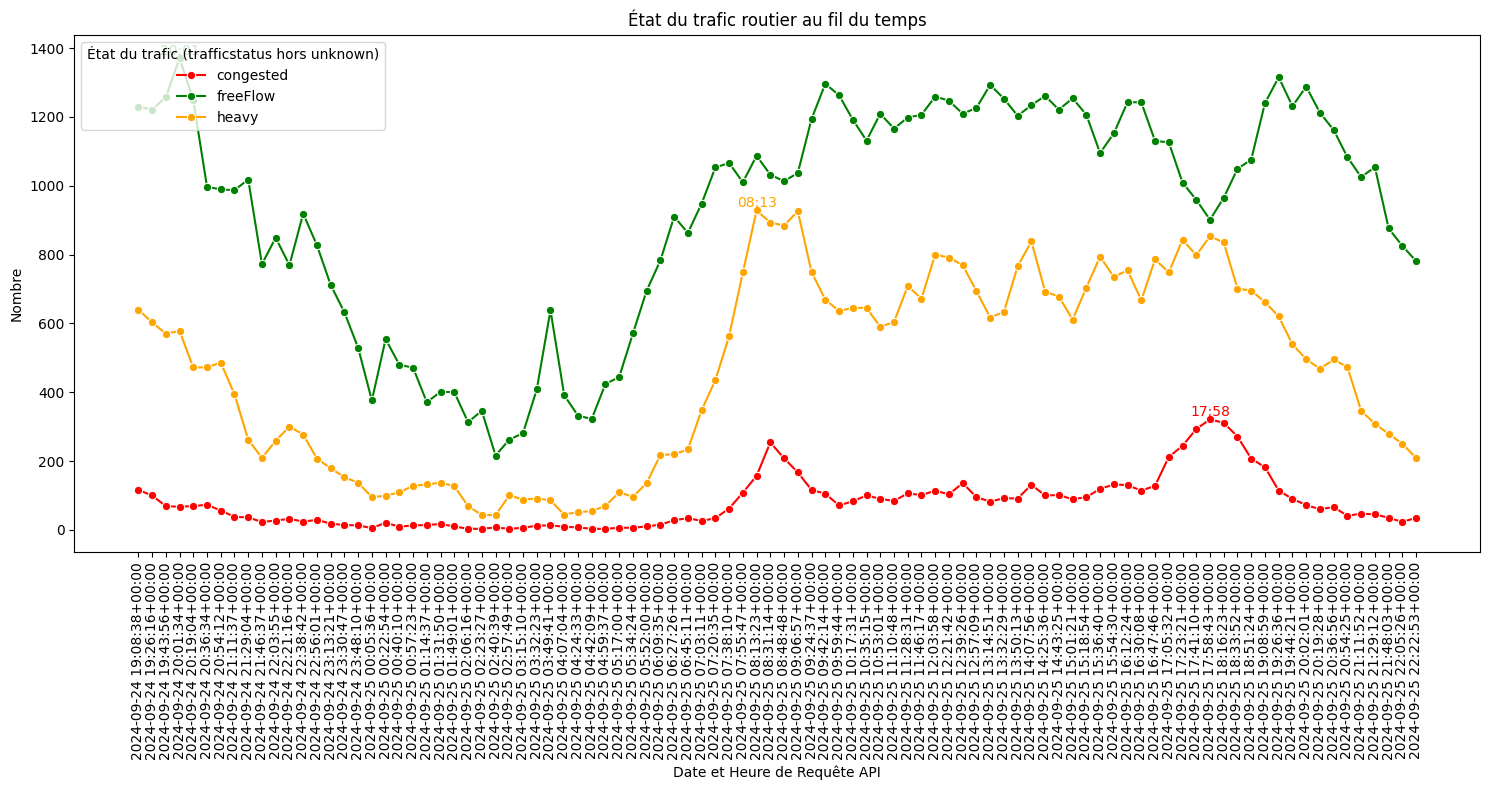

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrer le DataFrame pour exclure la catégorie 'unknown' dans 'trafficstatus'
df_filtered = df_routier[df_routier['trafficstatus'] != 'unknown']

# Regrouper par 'date_heure_requete_API' et 'trafficstatus', puis compter les occurrences
df_count = df_filtered.groupby(['date_heure_requete_API', 'trafficstatus']).size().reset_index(name='count')

# Créer un dictionnaire pour les couleurs personnalisées
palette = {'freeFlow': 'green', 'heavy': 'orange', 'congested': 'red'}

# Créer le graphique en courbe avec Seaborn
plt.figure(figsize=(15, 8))
sns.lineplot(x='date_heure_requete_API', y='count', hue='trafficstatus', data=df_count, palette=palette, marker='o')

# Identifier et annoter les pics pour chaque état du trafic
for status in df_count['trafficstatus'].unique():
    df_status = df_count[df_count['trafficstatus'] == status]
    max_idx = df_status['count'].idxmax()  # Trouver l'index de la valeur maximale
    max_time = df_status.loc[max_idx, 'date_heure_requete_API']
    max_count = df_status.loc[max_idx, 'count']

    # Extraire uniquement l'heure du champ 'date_heure_requete_API'
    max_time_str = pd.to_datetime(max_time).strftime('%H:%M')

    # Annoter le pic avec l'heure correspondante
    plt.text(max_time, max_count, f'{max_time_str}', color=palette[status], ha='center', va='bottom')

# Ajuster l'affichage
plt.title('État du trafic routier au fil du temps')
plt.xlabel('Date et Heure de Requête API')
plt.ylabel('Nombre')
plt.xticks(rotation=90)  # Rotation des étiquettes en abscisse pour améliorer la lisibilité
plt.legend(title='État du trafic (trafficstatus hors unknown)')

# Afficher le graphique
plt.tight_layout()
plt.show()



In [ ]:
df_routier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231992 entries, 0 to 231991
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 231992 non-null  object 
 1   nomcourtligne           231992 non-null  object 
 2   sens                    0 non-null       float64
 3   destination             231992 non-null  object 
 4   idarret                 0 non-null       float64
 5   nomarret                0 non-null       float64
 6   lon                     231992 non-null  float64
 7   lat                     231992 non-null  float64
 8   arriveetheorique        0 non-null       float64
 9   departtheorique         0 non-null       float64
 10  arrivee                 0 non-null       float64
 11  depart                  0 non-null       float64
 12  idcourse                0 non-null       float64
 13  precision               0 non-null       float64
 14  visibilite          

In [ ]:
df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290673 entries, 0 to 290672
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 290673 non-null  int64  
 1   nomcourtligne           290673 non-null  object 
 2   sens                    290673 non-null  int64  
 3   destination             289749 non-null  object 
 4   idarret                 290673 non-null  int64  
 5   nomarret                290673 non-null  object 
 6   lon                     290673 non-null  float64
 7   lat                     290673 non-null  float64
 8   arriveetheorique        290673 non-null  object 
 9   departtheorique         290673 non-null  object 
 10  arrivee                 290673 non-null  object 
 11  depart                  290673 non-null  object 
 12  idcourse                290673 non-null  int64  
 13  precision               290673 non-null  object 
 14  visibilite          

In [ ]:
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16970 entries, 0 to 16969
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   idligne                 16970 non-null  int64  
 1   nomcourtligne           16970 non-null  object 
 2   sens                    16970 non-null  int64  
 3   destination             16970 non-null  object 
 4   idarret                 16970 non-null  int64  
 5   nomarret                16970 non-null  object 
 6   lon                     16970 non-null  float64
 7   lat                     16970 non-null  float64
 8   arriveetheorique        0 non-null      float64
 9   departtheorique         0 non-null      float64
 10  arrivee                 15241 non-null  object 
 11  depart                  12775 non-null  object 
 12  idcourse                0 non-null      float64
 13  precision               16970 non-null  object 
 14  visibilite              0 non-null    

In [ ]:
df_metro.head()

idligne nomcourtligne  sens destination  idarret      nomarret       lon  \
0     1001             a     0  La Poterie     5001  J.F. Kennedy -1.710943   
1     1001             a     0  La Poterie     5001  J.F. Kennedy -1.710943   
2     1001             a     0  La Poterie     5001  J.F. Kennedy -1.710943   
3     1001             a     0  La Poterie     5001  J.F. Kennedy -1.710943   
4     1001             a     0  La Poterie     5001  J.F. Kennedy -1.710943   

         lat  arriveetheorique  departtheorique  ...  \
0  48.121295               NaN              NaN  ...   
1  48.121295               NaN              NaN  ...   
2  48.121295               NaN              NaN  ...   
3  48.121295               NaN              NaN  ...   
4  48.121295               NaN              NaN  ...   

                      depart idcourse       precision visibilite  \
0  2024-09-24T17:08:29+00:00      NaN  ['Temps réel']        NaN   
1  2024-09-24T17:13:22+00:00      NaN  ['Applicable']        NaN   
2  2024-09-24T17:18:16+00:00      NaN  ['Applicable']        NaN   
3  2024-09-24T17:33:07+00:00      NaN  ['Applicable']        NaN   
4  2024-09-24T17:35:34+00:00      NaN  ['Applicable']        NaN   

   heureextraction  trafficstatus  averagevehiclespeed  vitesse_maxi  \
0              NaN            NaN                  NaN           NaN   
1              NaN            NaN                  NaN           NaN   
2              NaN            NaN                  NaN           NaN   
3              NaN            NaN                  NaN           NaN   
4              NaN            NaN                  NaN           NaN   

      date_heure_requete_API transport_API  
0  2024-09-24 19:08:38+00:00         metro  
1  2024-09-24 19:08:38+00:00         metro  
2  2024-09-24 19:08:38+00:00         metro  
3  2024-09-24 19:08:38+00:00         metro  
4  2024-09-24 19:08:38+00:00         metro  

[5 rows x 21 columns]

In [ ]:
df_routier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231992 entries, 0 to 231991
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 231992 non-null  object 
 1   nomcourtligne           231992 non-null  object 
 2   sens                    0 non-null       float64
 3   destination             231992 non-null  object 
 4   idarret                 0 non-null       float64
 5   nomarret                0 non-null       float64
 6   lon                     231992 non-null  float64
 7   lat                     231992 non-null  float64
 8   arriveetheorique        0 non-null       float64
 9   departtheorique         0 non-null       float64
 10  arrivee                 0 non-null       float64
 11  depart                  0 non-null       float64
 12  idcourse                0 non-null       float64
 13  precision               0 non-null       float64
 14  visibilite          

In [ ]:
df_bus[['depart','arrivee','arriveetheorique','date_heure_requete_API']]
print(f"depart           => min: {df_bus.depart.min()} || max: {df_bus.depart.max()}")
print(f"arrivee          => min: {df_bus.arrivee.min()} || max: {df_bus.arrivee.max()}")
print(f"arriveetheorique => min: {df_bus.arriveetheorique.min()} || max: {df_bus.arriveetheorique.max()}")
print(f"date API         => min: {df_bus.date_heure_requete_API.min()} || max: {df_bus.date_heure_requete_API.max()}\n")

df_time_outlier = df_bus[['idligne','idcourse','depart','arrivee','arriveetheorique','date_heure_requete_API']].copy()

# Conversion date au format datetime
df_time_outlier['depart'] = pd.to_datetime(df_time_outlier['depart'], errors='coerce')
df_time_outlier['arrivee'] = pd.to_datetime(df_time_outlier['arrivee'], errors='coerce')
df_time_outlier['arriveetheorique'] = pd.to_datetime(df_time_outlier['arriveetheorique'], errors='coerce')
df_time_outlier['date_heure_requete_API'] = pd.to_datetime(df_time_outlier['date_heure_requete_API'], errors='coerce')

mask_time_outlier = (df_time_outlier.depart < df_time_outlier.date_heure_requete_API.min()) | (df_time_outlier.arrivee < df_time_outlier.date_heure_requete_API.min()) | (df_time_outlier.arriveetheorique < df_time_outlier.date_heure_requete_API.min()) | (df_time_outlier.depart > df_time_outlier.date_heure_requete_API.max()) | (df_time_outlier.arrivee > df_time_outlier.date_heure_requete_API.max()) | (df_time_outlier.arriveetheorique > df_time_outlier.date_heure_requete_API.max())
df_time_outlier = df_time_outlier.loc[mask_time_outlier]

print(f"nombre outlier: {len(df_time_outlier)} versus nombre total: {len(df_bus)}")
print(f"nombre idligne unique dans df_outlier: {df_time_outlier.idligne.nunique()} vs {df_bus.idligne.nunique()}")
print(f"nombre idcourse unique dans df_outlier: {df_time_outlier.idcourse.nunique()} vs {df_bus.idcourse.nunique()}")


depart           => min: 2024-09-24T17:04:15+00:00 || max: 2024-09-25T23:18:00+00:00
arrivee          => min: 2024-09-24T16:46:51+00:00 || max: 2024-09-26T21:58:00+00:00
arriveetheorique => min: 2024-09-23T22:00:00+00:00 || max: 2024-09-26T21:58:00+00:00
date API         => min: 2024-09-24 19:08:38+00:00 || max: 2024-09-25 22:22:52+00:00

nombre outlier: 15733 versus nombre total: 290673
nombre idligne unique dans df_outlier: 54 vs 64
nombre idcourse unique dans df_outlier: 523 vs 3345


In [ ]:
### ETAPE 2 => CONCATENATION DES DATAFRAME POUR LES DIFFERENTS MOYENS DE TRANSPORT REQUETES (BUS, METRO, ROUTIER) /// ** TO KEEP **
##  Rem: Possible car même format de colonne (homogénéisation des intitulés) --> facilite le traitement des données (nettoyage, ajout colonne, analyses exploratoires)

df_all_transport = pd.concat([df_bus, df_metro, df_routier], ignore_index=True)
df_all_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539635 entries, 0 to 539634
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 539635 non-null  object 
 1   nomcourtligne           539635 non-null  object 
 2   sens                    307643 non-null  float64
 3   destination             538711 non-null  object 
 4   idarret                 307643 non-null  float64
 5   nomarret                307643 non-null  object 
 6   lon                     539635 non-null  float64
 7   lat                     539635 non-null  float64
 8   arriveetheorique        290673 non-null  object 
 9   departtheorique         290673 non-null  object 
 10  arrivee                 305914 non-null  object 
 11  depart                  303448 non-null  object 
 12  idcourse                290673 non-null  float64
 13  precision               307643 non-null  object 
 14  visibilite          

In [ ]:
### Identification des doublons => En supprimant la colonne 'heureextraction' de l'analyse on trouve 20229 doublons soit quasi 50% du dataframe initial
### A priori pertinent de supprimer les doublons pour ne pas double compter les trajet dans une vision globale --> pour KPI par ex
### En revanche, pour des analyse par tranche horaire, il faut faire attention de supprimer les doublons de la tranche horaire dite uniquement --> pour KPI par ex
print(f"Nombre de doublons dans le dataframe original (toutes colonnes prises en compte): {df_all_transport.duplicated().sum()}")
print(f"Nombre de doublons dans le dataframe hors colonne 'heureextraction': {df_all_transport.drop(columns=['heureextraction','date_heure_requete_API']).duplicated().sum()}")


Nombre de doublons dans le dataframe original (toutes colonnes prises en compte): 0
Nombre de doublons dans le dataframe hors colonne 'heureextraction': 307890


In [ ]:
### Comparaison des colonnes 'arriveetheorique' / 'departtheorique' et 'arrivee' / 'depart'
# mask_theorique = (df_combined['arriveetheorique'] != df_combined['arrivee']) | (df_combined['departtheorique'] != df_combined['depart'])
print(f"Rappel nombre total de lignes du dataframe: {len(df_all_transport)}")
mask_theorique = (df_all_transport.arriveetheorique == df_all_transport.departtheorique)
print(f"Nombre de lignes dont les valeurs des colonnes 'departtheorique' et 'arriveetheorique' sont identiques: {len(df_all_transport.loc[mask_theorique])}")
mask_reel = (df_all_transport.arrivee == df_all_transport.depart)
print(f"Nombre de lignes dont les valeurs des colonnes 'depart' et 'arrivee' sont identiques: {len(df_all_transport.loc[mask_reel])}")
# display(df_combined.loc[~mask_theorique])
mask_retard = (df_all_transport.arrivee == df_all_transport.arriveetheorique)
print(f"Nombre de lignes du df dont les valeurs des colonnes 'arrivee' et 'arriveetheorique' sont identiques / pas de retard: {len(df_all_transport.loc[mask_retard])}")
print(f"Autrement dit, nombre de lignes du df pour lesquelles un retard est identifié: {len(df_all_transport) - len(df_all_transport.loc[mask_retard])}")

Rappel nombre total de lignes du dataframe: 539635
Nombre de lignes dont les valeurs des colonnes 'departtheorique' et 'arriveetheorique' sont identiques: 290174
Nombre de lignes dont les valeurs des colonnes 'depart' et 'arrivee' sont identiques: 283163
Nombre de lignes du df dont les valeurs des colonnes 'arrivee' et 'arriveetheorique' sont identiques / pas de retard: 233385
Autrement dit, nombre de lignes du df pour lesquelles un retard est identifié: 306250


In [ ]:
### ETAPE 3 => NETTOYAGE DES DONNEES --> 1. REMPLACEMENT DES VALEURS MANQUANTES PAR 0 /// ** TO KEEP **
df_all_transport.fillna(0, inplace=True)
df_all_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539635 entries, 0 to 539634
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idligne                 539635 non-null  object 
 1   nomcourtligne           539635 non-null  object 
 2   sens                    539635 non-null  float64
 3   destination             539635 non-null  object 
 4   idarret                 539635 non-null  float64
 5   nomarret                539635 non-null  object 
 6   lon                     539635 non-null  float64
 7   lat                     539635 non-null  float64
 8   arriveetheorique        539635 non-null  object 
 9   departtheorique         539635 non-null  object 
 10  arrivee                 539635 non-null  object 
 11  depart                  539635 non-null  object 
 12  idcourse                539635 non-null  float64
 13  precision               539635 non-null  object 
 14  visibilite          

In [ ]:
### ETAPE 3 => NETTOYAGE DES DONNEES --> 2. CONVERSION DES COLONNES DATE AU FORMAT DATETIME /// ** TO KEEP **
### Rem : Gestion des erreurs via errors='coerce' (ex. 0 sur les lignes flagguées 'metro' et 'routier' car info manquante)

## Conversion des colonnes 'depart','arrivee','departtheorique','arriveetheorique', 'date_heure_requete_API' en format datetime avec pandas
df_all_transport['depart'] = pd.to_datetime(df_all_transport['depart'], errors='coerce')
df_all_transport['arrivee'] = pd.to_datetime(df_all_transport['arrivee'], errors='coerce')
df_all_transport['departtheorique'] = pd.to_datetime(df_all_transport['departtheorique'], errors='coerce')
df_all_transport['arriveetheorique'] = pd.to_datetime(df_all_transport['arriveetheorique'], errors='coerce')
df_all_transport['date_heure_requete_API'] = pd.to_datetime(df_all_transport['date_heure_requete_API'], errors='coerce')
df_all_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539635 entries, 0 to 539634
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   idligne                 539635 non-null  object             
 1   nomcourtligne           539635 non-null  object             
 2   sens                    539635 non-null  float64            
 3   destination             539635 non-null  object             
 4   idarret                 539635 non-null  float64            
 5   nomarret                539635 non-null  object             
 6   lon                     539635 non-null  float64            
 7   lat                     539635 non-null  float64            
 8   arriveetheorique        290673 non-null  datetime64[ns, UTC]
 9   departtheorique         290673 non-null  datetime64[ns, UTC]
 10  arrivee                 290673 non-null  datetime64[ns, UTC]
 11  depart                  30

In [ ]:
df_all_transport.date_heure_requete_API.unique()

<DatetimeArray>
['2024-09-24 19:08:38+00:00', '2024-09-24 19:26:16+00:00',
 '2024-09-24 19:43:56+00:00', '2024-09-24 20:01:34+00:00',
 '2024-09-24 20:19:04+00:00', '2024-09-24 20:36:34+00:00',
 '2024-09-24 20:54:12+00:00', '2024-09-24 21:11:37+00:00',
 '2024-09-24 21:29:04+00:00', '2024-09-24 21:46:37+00:00',
 '2024-09-24 22:03:55+00:00', '2024-09-24 22:21:16+00:00',
 '2024-09-24 22:38:42+00:00', '2024-09-24 22:56:01+00:00',
 '2024-09-24 23:13:21+00:00', '2024-09-24 23:30:47+00:00',
 '2024-09-24 23:48:10+00:00', '2024-09-25 00:05:36+00:00',
 '2024-09-25 00:22:54+00:00', '2024-09-25 00:40:10+00:00',
 '2024-09-25 00:57:23+00:00', '2024-09-25 01:14:37+00:00',
 '2024-09-25 01:31:50+00:00', '2024-09-25 01:49:01+00:00',
 '2024-09-25 02:06:16+00:00', '2024-09-25 02:23:27+00:00',
 '2024-09-25 02:40:39+00:00', '2024-09-25 02:57:49+00:00',
 '2024-09-25 03:15:10+00:00', '2024-09-25 03:32:23+00:00',
 '2024-09-25 03:49:41+00:00', '2024-09-25 04:07:04+00:00',
 '2024-09-25 04:24:33+00:00', '2024-09-2

In [ ]:
### ETAPE 3 => NETTOYAGE DES DONNEES --> 3. VERIFICATION QUE LES COORDONNEES GEOGRAPHIQUES SONT BIEN UNIQUES PAR NOM D'ARRET

# Groupby sur 'idarret' et 'nomarret', puis compter le nombre de combinaisons uniques de 'lon' et 'lat'
df_check_unique_coords = df_all_transport.groupby(['idarret', 'nomarret'])[['lon', 'lat']].nunique().reset_index()

# Filtrer les arrêts qui ont plus d'une combinaison unique de coordonnées
df_non_unique_coords = df_check_unique_coords[df_check_unique_coords[['lon', 'lat']].max(axis=1) > 1]

# Afficher le résultat
display(df_non_unique_coords)


idarret nomarret   lon   lat
0      0.0        0  2468  2468

In [ ]:
### ETAPE 3 => NETTOYAGE DES DONNEES --> 4. DETERMINATION DES OUTLIERS // fonction

def detect_outliers_iqr(df, column):
    # Calcul des quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes pour les valeurs aberrantes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Borne inférieure : {lower_bound}, Borne supérieure : {upper_bound}")

    # # Filtrer les outliers
    # outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return lower_bound, upper_bound

retard min en minutes: -1434.15
retard Q1: 0.0
retard Q2 ou mediane: 0.0
retard Q3: 0.0
retard max en minutes: 1438.3666666666666
retard moyen en minutes: -0.001943707648571883

Nombre de retard >= 70 minutes: 1
Nombre de retard > 0 et < 70: 41168
Nombre de non retard, ie = 0: 233385
Nombre d'arrivées anticipées < 0: 16119
Borne inférieure : 0.0, Borne supérieure : 0.0

Bornes outliers: (0.0, 0.0)
32384
32145


idligne nomcourtligne  sens      destination  idarret    nomarret  \
32384       2            C2   1.0  Cesson-Viasilva   1315.0  République   
32145       7            C7   0.0             Bruz   2334.0     Pasteur   

            lon        lat          arriveetheorique  \
32384 -1.678055  48.109716 2024-09-25 21:58:00+00:00   
32145 -1.736063  48.023836 2024-09-23 22:00:00+00:00   

                departtheorique                   arrivee  \
32384 2024-09-24 22:05:00+00:00 2024-09-24 22:03:51+00:00   
32145 2024-09-23 22:00:00+00:00 2024-09-24 21:58:22+00:00   

                         depart     idcourse   precision    visibilite  \
32384 2024-09-24 22:05:00+00:00  268435993.0  Temps réel  Grand public   
32145 2024-09-24 21:58:22+00:00  268437061.0  Temps réel  Grand public   

      heureextraction trafficstatus  averagevehiclespeed  vitesse_maxi  \
32384        00:02:10             0                  0.0           0.0   
32145        23:44:10             0                  0.0           0.0   

         date_heure_requete_API transport_API       retard  
32384 2024-09-25 00:05:36+00:00           bus -1434.150000  
32145 2024-09-24 23:48:10+00:00           bus  1438.366667

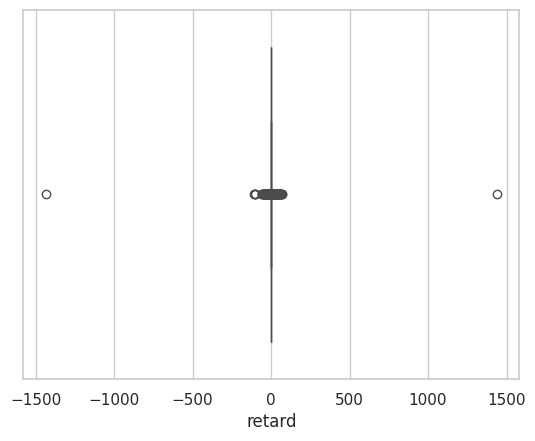

In [ ]:
### ETAPE 3 => NETTOYAGE DES DONNEES --> Zoom variables 'arrivee' et 'arriveetheorique' /// cohérence des valeurs en delta (retard)
## Subset retard qui représente la différence entre l'heure réelle d'arrivée 'arrivee' et l'heure théorique 'arriveetheorique'
### + étude de la distribution de la variable 'retard' pour vérifier si valeurs aberrantes

df_all_retard = df_all_transport.copy()
df_all_retard['retard'] = (df_all_retard['arrivee'] - df_all_retard['arriveetheorique']).dt.total_seconds() / 60  # en minutes
print(f"retard min en minutes: {df_all_retard['retard'].min()}")
print(f"retard Q1: {df_all_retard['retard'].quantile(0.25)}")
print(f"retard Q2 ou mediane: {df_all_retard['retard'].quantile(0.5)}")
print(f"retard Q3: {df_all_retard['retard'].quantile(0.75)}")
print(f"retard max en minutes: {df_all_retard['retard'].max()}")
print(f"retard moyen en minutes: {df_all_retard['retard'].mean()}")

## Zoom retard > 70 ou retard < 0
print(f"\nNombre de retard >= 70 minutes: {len(df_all_retard[df_all_retard['retard'] >= 70])}")
print(f"Nombre de retard > 0 et < 70: {len(df_all_retard[(df_all_retard['retard'] > 0) & (df_all_retard['retard'] < 70)])}")
print(f"Nombre de non retard, ie = 0: {len(df_all_retard[df_all_retard['retard'] == 0])}")
print(f"Nombre d'arrivées anticipées < 0: {len(df_all_retard[df_all_retard['retard'] < 0])}")

## Utilisation fonction détection outliers pour déterminer les bornes
print(f"\nBornes outliers: {detect_outliers_iqr(df_all_retard, 'retard')}")

## Affichage des lignes min et max
print(df_all_retard.retard.idxmin())
print(df_all_retard.retard.idxmax())
pd.set_option('display.max_columns', None)
display(df_all_retard.iloc[[df_all_retard.retard.idxmin(),df_all_retard.retard.idxmax()]])

## boxplot retard pour observer la distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x=df_all_retard['retard'])
plt.show()


In [ ]:
mask_check = (df_all_transport.idcourse == 268440518.0) # & (df_all_transport.destination == "Betton | Chevaigné") & (df_all_transport.nomarret == "Les Gayeulles")
df_all_transport.loc[mask_check,['idcourse','destination','nomarret','depart','arrivee','arriveetheorique','date_heure_requete_API','precision']].sort_values(by=['date_heure_requete_API','depart'])

idcourse destination        nomarret                    depart  \
147164  268440518.0   Pont-Péan  Henri Fréville 2024-09-25 12:15:00+00:00   
147165  268440518.0   Pont-Péan         Norvège 2024-09-25 12:19:00+00:00   
147166  268440518.0   Pont-Péan       Coubertin 2024-09-25 12:20:00+00:00   
147167  268440518.0   Pont-Péan     Félix Eboué 2024-09-25 12:22:00+00:00   
151137  268440518.0   Pont-Péan          Vallon 2024-09-25 12:26:00+00:00   
...             ...         ...             ...                       ...   
187415  268440518.0   Pont-Péan      Rivaudière 2024-09-25 12:48:24+00:00   
187416  268440518.0   Pont-Péan     Chemin Vert 2024-09-25 12:50:24+00:00   
187417  268440518.0   Pont-Péan        Caliorne 2024-09-25 12:52:24+00:00   
191900  268440518.0   Pont-Péan     Cornouaille 2024-09-25 12:39:30+00:00   
191901  268440518.0   Pont-Péan  Constant Mérel 2024-09-25 12:42:30+00:00   

                         arrivee          arriveetheorique  \
147164 2024-09-25 12:15:00+00:00 2024-09-25 12:15:00+00:00   
147165 2024-09-25 12:19:00+00:00 2024-09-25 12:19:00+00:00   
147166 2024-09-25 12:20:00+00:00 2024-09-25 12:20:00+00:00   
147167 2024-09-25 12:22:00+00:00 2024-09-25 12:22:00+00:00   
151137 2024-09-25 12:26:00+00:00 2024-09-25 12:26:00+00:00   
...                          ...                       ...   
187415 2024-09-25 12:48:24+00:00 2024-09-25 12:48:00+00:00   
187416 2024-09-25 12:50:24+00:00 2024-09-25 12:50:00+00:00   
187417 2024-09-25 12:52:24+00:00 2024-09-25 12:52:00+00:00   
191900 2024-09-25 12:39:30+00:00 2024-09-25 12:40:00+00:00   
191901 2024-09-25 12:42:30+00:00 2024-09-25 12:43:00+00:00   

          date_heure_requete_API   precision  
147164 2024-09-25 11:28:31+00:00  Applicable  
147165 2024-09-25 11:28:31+00:00  Applicable  
147166 2024-09-25 11:28:31+00:00  Applicable  
147167 2024-09-25 11:28:31+00:00  Applicable  
151137 2024-09-25 11:46:16+00:00  Applicable  
...                          ...         ...  
187415 2024-09-25 14:25:36+00:00  Temps réel  
187416 2024-09-25 14:25:36+00:00  Temps réel  
187417 2024-09-25 14:25:36+00:00  Temps réel  
191900 2024-09-25 14:43:25+00:00  Temps réel  
191901 2024-09-25 14:43:25+00:00  Temps réel  

[76 rows x 8 columns]

In [ ]:
### ETAPE 4 => CREATION SUBSET AGGREGE PAR IDCOURSE -> OBJECTIF = CALCULER NOMBRE ARRETS, DUREE TRAJET, RETARD OBSERVES AU GLOBAL POUR CHAQUE TRAJET
## Obj : Déterminer la durée des trajets => duree_trajet = différence entre l'heure d'arrivée max 'arrivee' et l'heure de départ min 'depart' par idcourse
## Obj : Déterminer les retard par trajet => retard = différence entre l'heure d'arrivée max 'arrivee' et l'heure d'arrivée théorique max 'arriveetheorique' par idcourse
## + étude de la distribution de la variable 'duree_trajet' pour vérifier si valeurs aberrantes

# Calculer le départ minimum, l'arrivée maximale et le nombre d'arrêts par idcourse x date-heure de requetage API
df_trajet = df_all_transport.groupby(['idcourse','date_heure_requete_API']).agg(
    depart_min=pd.NamedAgg(column='depart', aggfunc='min'),
    arrivee_max=pd.NamedAgg(column='arrivee', aggfunc='max'),
    arrivee_theo_max=pd.NamedAgg(column='arriveetheorique', aggfunc='max'),
    nb_arret=pd.NamedAgg(column='arriveetheorique', aggfunc='count')
).reset_index()

# Ajout colonne 'duree_trajet' pour calculer la durée du trajet (arrivee_max - depart_min) en minutes
df_trajet['duree_trajet'] = (df_trajet['arrivee_max'] - df_trajet['depart_min']).dt.total_seconds() / 60 ## si supp ".dt.total_seconds() / 60" -> format day, hh:mm:ss -- mais pb affichage qd delta negatif car il considère day=-1

# Ajout colonne 'retard' pour calculer le retard total du trajet (arrivee_max - arrivee_theo_max) en minutes
df_trajet['retard'] = (df_trajet['arrivee_max'] - df_trajet['arrivee_theo_max']).dt.total_seconds() / 60 ## si supp ".dt.total_seconds() / 60" -> format day, hh:mm:ss

# Fusionner avec les colonnes idligne et nomcourtligne en évitant les doublons
df_trajet = pd.merge(
    df_trajet,
    df_all_transport[['idcourse', 'idligne', 'nomcourtligne', 'destination']].drop_duplicates('idcourse'),
    on='idcourse',
    how='left'
)

# ENREGISTREMENT DU SUBSET AGGREGE AU FORMAT CSV POUR VISUALISATION DANS POWER BI ==>
output_csv_path = f'/content/drive/My Drive/Projet3/df_trajet_agg.csv'
df_trajet.to_csv(output_csv_path, index=False)


# # Suppression lignes index=83, 911, 761, 645, 8, 52, 170 identifiées comme valeur aberrante -> durée min = -1 days +23:51:00
# mask_duree_trajet_nulle = df_trajet.loc[df_trajet['duree_trajet']<='0 days 00:00:00']
# print(len(mask_duree_trajet_nulle))
# df_trajet = df_trajet(~mask_duree_trajet_nulle)

### Affichage des résultats
# df_trajet.info()
# display(df_trajet[['idcourse', 'idligne', 'nomcourtligne', 'destination', 'depart_min', 'arrivee_max', 'duree_trajet', 'retard']].sort_values(by=['idligne','depart_min'], ascending=True))
# display(df_trajet.groupby(by='idligne').duree_trajet.mean())
print(f"taille dataframe: {len(df_trajet)}\n")
print(f"nombre idcourse uniques: {df_trajet.idcourse.nunique()}")
# print(f"nombre date/heure requete API uniques: {df_trajet.date_heure_requete_API.nunique()}\n")
print(f"duree moyenne de l'ensemble des trajets: {df_trajet.duree_trajet.mean().round()}")
print(f"duree max observée sur l'ensemble des trajets: {df_trajet.duree_trajet.max().round()}")
print(f"duree min observée sur l'ensemble des trajets: {df_trajet.duree_trajet.min().round()}\n")
# display(df_trajet.groupby(by='idligne').retard.mean())
print(f"retard moyen de l'ensemble des trajets: {df_trajet.retard.mean().round()}")
print(f"retard max observé sur l'ensemble des trajets: {df_trajet.retard.max().round()}")
print(f"retard min observé sur l'ensemble des trajets: {df_trajet.retard.min().round()}\n")
# display(df_trajet.groupby(by='idligne').retard.mean())
print(f"nombre moyen d'arrêts sur l'ensemble des trajets: {df_trajet.nb_arret.mean().round()}")
print(f"nombre max de stations observé sur l'ensemble des trajets: {df_trajet.nb_arret.max().round()}")
print(f"nombre min de stations observé sur l'ensemble des trajets: {df_trajet.nb_arret.min().round()}\n")

## zoom valeurs aberrantes -> durée min = -1 days +23:51:00 identifiée pour index = 83 par ex mais pb. résolu en introduisant ".dt.total_seconds() / 60" dans calcul
print(df_trajet.retard.idxmin())
print(df_trajet.duree_trajet.idxmax())
display(df_trajet.iloc[df_trajet.duree_trajet.idxmax()])
print()

## durée et retard moyen observé sur le idligne souhaitée (qui est la ligne de bus pour laquelle on observe la + petite durée et + petit retard)
print(df_trajet.idligne.unique())
input_idligne = 200
mask_ligne = (df_trajet.idligne == input_idligne)
print(f"\nretard moyen ligne {input_idligne}: {df_trajet[mask_ligne].retard.mean().round()}")
print(f"duree trajet moyen ligne {input_idligne}: {df_trajet[mask_ligne].duree_trajet.mean().round()}")
print(f"nb arrêts moyen ligne {input_idligne}: {df_trajet[mask_ligne].nb_arret.mean().round()}")


taille dataframe: 37005

nombre idcourse uniques: 3346
duree moyenne de l'ensemble des trajets: 24.0
duree max observée sur l'ensemble des trajets: 1459.0
duree min observée sur l'ensemble des trajets: -34.0

retard moyen de l'ensemble des trajets: 0.0
retard max observé sur l'ensemble des trajets: 68.0
retard min observé sur l'ensemble des trajets: -1415.0

nombre moyen d'arrêts sur l'ensemble des trajets: 8.0
nombre max de stations observé sur l'ensemble des trajets: 43
nombre min de stations observé sur l'ensemble des trajets: 0

1779
1776


idcourse                                268435993.0
date_heure_requete_API    2024-09-24 23:13:21+00:00
depart_min                2024-09-24 21:39:02+00:00
arrivee_max               2024-09-25 21:58:00+00:00
arrivee_theo_max          2024-09-25 21:58:00+00:00
nb_arret                                         27
duree_trajet                            1458.966667
retard                                          0.0
idligne                                           2
nomcourtligne                                    C2
destination                         Cesson-Viasilva
Name: 1776, dtype: object


[1001 1 153 2 64 6 3 4 5 53 7 47 10 11 12 13 14 152 54 55 154 155 156 59
 159 161 74 61 164 165 168 173 75 175 178 78 200 32 34 37 38 39 50 51 52
 56 62 65 67 167 68 70 71 72 80 172 79 73 76 77 81 82 83 90 91]

retard moyen ligne 200: 1.0
duree trajet moyen ligne 200: 26.0
nb arrêts moyen ligne 200: 12.0


In [ ]:
df_trajet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37005 entries, 0 to 37004
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   idcourse                37005 non-null  float64            
 1   date_heure_requete_API  37005 non-null  datetime64[ns, UTC]
 2   depart_min              37004 non-null  datetime64[ns, UTC]
 3   arrivee_max             36910 non-null  datetime64[ns, UTC]
 4   arrivee_theo_max        36910 non-null  datetime64[ns, UTC]
 5   nb_arret                37005 non-null  int64              
 6   duree_trajet            36910 non-null  float64            
 7   retard                  36910 non-null  float64            
 8   idligne                 37005 non-null  object             
 9   nomcourtligne           37005 non-null  object             
 10  destination             37005 non-null  object             
dtypes: datetime64[ns, UTC](4), float64(3), in

In [ ]:
mask_check = (df_all_transport.idcourse == 268440438.0) # & (df_all_transport.destination == "Betton | Chevaigné") & (df_all_transport.nomarret == "Les Gayeulles")
df_all_transport.loc[mask_check,['idcourse','idligne','destination','nomarret','depart','arrivee','arriveetheorique','date_heure_requete_API','precision']].sort_values(by=['date_heure_requete_API','depart'])

idcourse idligne destination              nomarret  \
2745   268440438.0      68      Gévezé             La Brosse   
2817   268440438.0      68      Gévezé           Confortland   
2818   268440438.0      68      Gévezé                 Flume   
2746   268440438.0      68      Gévezé            Prés Verts   
2776   268440438.0      68      Gévezé              Coualeuc   
...            ...     ...         ...                   ...   
78211  268440438.0      71      Rennes        Gentilhommière   
78212  268440438.0      71      Rennes         Betton Centre   
78213  268440438.0      71      Rennes  Betton Rue de Rennes   
78162  268440438.0      71      Rennes       Enseigne Abbaye   
78163  268440438.0      71      Rennes       Hôtel de Région   

                         depart                   arrivee  \
2745  2024-09-24 17:08:21+00:00 2024-09-24 17:08:21+00:00   
2817  2024-09-24 17:10:21+00:00 2024-09-24 17:10:21+00:00   
2818  2024-09-24 17:17:21+00:00 2024-09-24 17:17:21+00:00   
2746  2024-09-24 17:20:21+00:00 2024-09-24 17:20:21+00:00   
2776  2024-09-24 17:21:21+00:00 2024-09-24 17:21:21+00:00   
...                         ...                       ...   
78211 2024-09-25 04:41:38+00:00 2024-09-25 04:41:38+00:00   
78212 2024-09-25 04:45:32+00:00 2024-09-25 04:45:32+00:00   
78213 2024-09-25 04:47:32+00:00 2024-09-25 04:47:32+00:00   
78162 2024-09-25 04:48:32+00:00 2024-09-25 04:48:32+00:00   
78163 2024-09-25 04:56:40+00:00 2024-09-25 04:56:40+00:00   

               arriveetheorique    date_heure_requete_API   precision  
2745  2024-09-24 17:06:00+00:00 2024-09-24 19:08:38+00:00  Temps réel  
2817  2024-09-24 17:08:00+00:00 2024-09-24 19:08:38+00:00  Temps réel  
2818  2024-09-24 17:15:00+00:00 2024-09-24 19:08:38+00:00  Temps réel  
2746  2024-09-24 17:18:00+00:00 2024-09-24 19:08:38+00:00  Temps réel  
2776  2024-09-24 17:19:00+00:00 2024-09-24 19:08:38+00:00  Temps réel  
...                         ...                       ...         ...  
78211 2024-09-25 04:40:00+00:00 2024-09-25 06:45:11+00:00  Temps réel  
78212 2024-09-25 04:43:00+00:00 2024-09-25 06:45:11+00:00  Temps réel  
78213 2024-09-25 04:45:00+00:00 2024-09-25 06:45:11+00:00  Temps réel  
78162 2024-09-25 04:46:00+00:00 2024-09-25 06:45:11+00:00  Temps réel  
78163 2024-09-25 04:54:00+00:00 2024-09-25 06:45:11+00:00  Temps réel  

[158 rows x 9 columns]

In [ ]:
# pd.set_option('display.max_columns', None)
# df_all_transport.head(25)

In [ ]:
### ETAPE 5 => AJOUT COLONNES DANS DATAFRAME NON AGREGE AVEC LES HORAIRES DES PROCHAINS PASSAGES ET CELUI DU DERNIER PASSAGE ///  **TO KEEP**

df_timetable_all = df_all_transport.copy()
print(f"taille df avant drop: {len(df_timetable_all)}\n")
print(f"Avant drop: {list(df_timetable_all.columns)}")

# Suppression des doublons
df_timetable_all = df_timetable_all.drop(columns=['idcourse','heureextraction','date_heure_requete_API','depart','arriveetheorique',
                                                  'departtheorique','precision','visibilite','trafficstatus','averagevehiclespeed',
                                                  'vitesse_maxi']).drop_duplicates()
print(f"Après drop: {list(df_timetable_all.columns)}\n")

# Trier le DataFrame par 'idligne', 'nomarret' et 'arrivee' pour assurer l'ordre chronologique
df_timetable_all = df_timetable_all.sort_values(by=['idligne', 'nomarret', 'arrivee'])

# Créer les colonnes 'next_depart_1', 'next_depart_2' et 'next_depart_3' pour les 3 prochains passages au même arrêt
df_timetable_all['next_depart_1'] = df_timetable_all.groupby(['idligne', 'nomarret'])['arrivee'].shift(-1)
df_timetable_all['next_depart_2'] = df_timetable_all.groupby(['idligne', 'nomarret'])['arrivee'].shift(-2)
df_timetable_all['next_depart_3'] = df_timetable_all.groupby(['idligne', 'nomarret'])['arrivee'].shift(-3)

# Créer la colonne 'previous_depart' pour le précédent passage au même arrêt
df_timetable_all['previous_depart'] = df_timetable_all.groupby(['idligne', 'nomarret'])['arrivee'].shift(1)

# Créer la colonne 'waiting_time' pour calculer le temps d'attente avant le prochain passage en minutes
df_timetable_all['waiting_time'] = (df_timetable_all.next_depart_1 - df_timetable_all.arrivee).dt.total_seconds() / 60

# Afficher le DataFrame avec les nouvelles colonnes
print(f"taille df après drop: {len(df_timetable_all)}\n")
display(df_timetable_all[['idligne','nomarret','arrivee','next_depart_1','next_depart_2','next_depart_3','previous_depart','waiting_time']].head(20))

# ENREGISTREMENT DU CSV POUR VISUALISATION DANS POWER BI ==>
output_csv_path = f'/content/drive/My Drive/Projet3/df_timetable_all.csv'
df_timetable_all.to_csv(output_csv_path, index=False)


taille df avant drop: 539635

Avant drop: ['idligne', 'nomcourtligne', 'sens', 'destination', 'idarret', 'nomarret', 'lon', 'lat', 'arriveetheorique', 'departtheorique', 'arrivee', 'depart', 'idcourse', 'precision', 'visibilite', 'heureextraction', 'trafficstatus', 'averagevehiclespeed', 'vitesse_maxi', 'date_heure_requete_API', 'transport_API']
Après drop: ['idligne', 'nomcourtligne', 'sens', 'destination', 'idarret', 'nomarret', 'lon', 'lat', 'arrivee', 'transport_API']

taille df après drop: 114826



idligne        nomarret                   arrivee  \
4003        1  Anatole France 2024-09-24 18:00:00+00:00   
7568        1  Anatole France 2024-09-24 18:15:00+00:00   
14169       1  Anatole France 2024-09-24 18:16:11+00:00   
3951        1  Anatole France 2024-09-24 18:30:00+00:00   
14192       1  Anatole France 2024-09-24 18:33:44+00:00   
3992        1  Anatole France 2024-09-24 18:47:00+00:00   
16          1  Anatole France 2024-09-24 19:03:00+00:00   
17179       1  Anatole France 2024-09-24 19:20:00+00:00   
11072       1  Anatole France 2024-09-24 19:23:00+00:00   
19725       1  Anatole France 2024-09-24 19:24:47+00:00   
7641        1  Anatole France 2024-09-24 19:58:00+00:00   
17157       1  Anatole France 2024-09-24 20:31:00+00:00   
14232       1  Anatole France 2024-09-24 21:06:00+00:00   
21948       1  Anatole France 2024-09-24 21:07:00+00:00   
21884       1  Anatole France 2024-09-24 21:40:00+00:00   
30794       1  Anatole France 2024-09-24 21:40:25+00:00   
30017       1  Anatole France 2024-09-24 21:41:21+00:00   
27398       1  Anatole France 2024-09-24 21:42:00+00:00   
23652       1  Anatole France 2024-09-24 22:15:00+00:00   
31626       1  Anatole France 2024-09-24 22:16:20+00:00   

                  next_depart_1             next_depart_2  \
4003  2024-09-24 18:15:00+00:00 2024-09-24 18:16:11+00:00   
7568  2024-09-24 18:16:11+00:00 2024-09-24 18:30:00+00:00   
14169 2024-09-24 18:30:00+00:00 2024-09-24 18:33:44+00:00   
3951  2024-09-24 18:33:44+00:00 2024-09-24 18:47:00+00:00   
14192 2024-09-24 18:47:00+00:00 2024-09-24 19:03:00+00:00   
3992  2024-09-24 19:03:00+00:00 2024-09-24 19:20:00+00:00   
16    2024-09-24 19:20:00+00:00 2024-09-24 19:23:00+00:00   
17179 2024-09-24 19:23:00+00:00 2024-09-24 19:24:47+00:00   
11072 2024-09-24 19:24:47+00:00 2024-09-24 19:58:00+00:00   
19725 2024-09-24 19:58:00+00:00 2024-09-24 20:31:00+00:00   
7641  2024-09-24 20:31:00+00:00 2024-09-24 21:06:00+00:00   
17157 2024-09-24 21:06:00+00:00 2024-09-24 21:07:00+00:00   
14232 2024-09-24 21:07:00+00:00 2024-09-24 21:40:00+00:00   
21948 2024-09-24 21:40:00+00:00 2024-09-24 21:40:25+00:00   
21884 2024-09-24 21:40:25+00:00 2024-09-24 21:41:21+00:00   
30794 2024-09-24 21:41:21+00:00 2024-09-24 21:42:00+00:00   
30017 2024-09-24 21:42:00+00:00 2024-09-24 22:15:00+00:00   
27398 2024-09-24 22:15:00+00:00 2024-09-24 22:16:20+00:00   
23652 2024-09-24 22:16:20+00:00 2024-09-24 22:16:38+00:00   
31626 2024-09-24 22:16:38+00:00 2024-09-24 22:42:00+00:00   

                  next_depart_3           previous_depart  waiting_time  
4003  2024-09-24 18:30:00+00:00                       NaT     15.000000  
7568  2024-09-24 18:33:44+00:00 2024-09-24 18:00:00+00:00      1.183333  
14169 2024-09-24 18:47:00+00:00 2024-09-24 18:15:00+00:00     13.816667  
3951  2024-09-24 19:03:00+00:00 2024-09-24 18:16:11+00:00      3.733333  
14192 2024-09-24 19:20:00+00:00 2024-09-24 18:30:00+00:00     13.266667  
3992  2024-09-24 19:23:00+00:00 2024-09-24 18:33:44+00:00     16.000000  
16    2024-09-24 19:24:47+00:00 2024-09-24 18:47:00+00:00     17.000000  
17179 2024-09-24 19:58:00+00:00 2024-09-24 19:03:00+00:00      3.000000  
11072 2024-09-24 20:31:00+00:00 2024-09-24 19:20:00+00:00      1.783333  
19725 2024-09-24 21:06:00+00:00 2024-09-24 19:23:00+00:00     33.216667  
7641  2024-09-24 21:07:00+00:00 2024-09-24 19:24:47+00:00     33.000000  
17157 2024-09-24 21:40:00+00:00 2024-09-24 19:58:00+00:00     35.000000  
14232 2024-09-24 21:40:25+00:00 2024-09-24 20:31:00+00:00      1.000000  
21948 2024-09-24 21:41:21+00:00 2024-09-24 21:06:00+00:00     33.000000  
21884 2024-09-24 21:42:00+00:00 2024-09-24 21:07:00+00:00      0.416667  
30794 2024-09-24 22:15:00+00:00 2024-09-24 21:40:00+00:00      0.933333  
30017 2024-09-24 22:16:20+00:00 2024-09-24 21:40:25+00:00      0.650000  
27398 2024-09-24 22:16:38+00:00 2024-09-24 21:41:21+00:00     33.000000  
23652 2024-09-24 22:42:00+00:00 2024-09-24 21:42:00+00:00      1.333333  
3162

In [ ]:
### ETAPE 6 => CREATION SUBSET AGGREGE PAR IDLIGNE AVEC LISTE DES ARRETS
### Obj : Obtenir la liste des arrêts par ligne de bus avec le nombre d'occurrences pour chaque arrêt sur la période de requêtage des données

# Groupby par 'idligne', 'idarret', 'nomarret', 'lon', 'lat' et compter les occurrences /// à voir si on garde 'destination'
df_agg_idligne = df_all_transport.groupby(['idligne','idarret', 'nomarret', 'lon', 'lat','transport_API']).size().reset_index(name='nb_occur')

# On ne garde que les bus et les métro car pas d'utilité pour le réseau routier
df_agg_idligne = df_agg_idligne[df_agg_idligne.transport_API.isin(['bus','metro'])]

# Afficher le DataFrame agrégé
display(df_agg_idligne)
print(f"nombre d'idligne distinct: {df_agg_idligne.idligne.nunique()}")
print(f"nombre d'idarret distinct: {df_agg_idligne.idarret.nunique()}")
print(f"nombre de nomarret distinct: {df_agg_idligne.nomarret.nunique()}")
print(f"nombre de lon/lat distinct: {df_agg_idligne.lon.nunique()} et {df_agg_idligne.lat.nunique()}")

idligne  idarret                      nomarret       lon        lat  \
0          1   1040.0                     Donelière -1.684309  48.129874   
1          1   1041.0                   Trois Croix -1.683692  48.129061   
2          1   1042.0                Cimetière Nord -1.681724  48.123939   
3          1   1043.0                  Saint-Martin -1.684238  48.123614   
4          1   1044.0                Pierre Legrand -1.685924  48.122179   
...      ...      ...                           ...       ...        ...   
2466    1002   5075.0                 Les Gayeulles -1.657618  48.129369   
2467    1002   5076.0  Joliot-Curie - Chateaubriand -1.651497  48.123814   
2468    1002   5077.0         Beaulieu - Université -1.638943  48.122140   
2469    1002   5078.0                      Atalante -1.627859  48.127153   
2470    1002   5079.0             Cesson - Viasilva -1.619862  48.131549   

     transport_API  nb_occur  
0              bus       179  
1              bus        31  
2              bus       172  
3              bus       177  
4              bus       160  
...            ...       ...  
2466         metro         8  
2467         metro         7  
2468         metro         7  
2469         metro         9  
2470         metro         2  

[2471 rows x 7 columns]

nombre d'idligne distinct: 66
nombre d'idarret distinct: 1485
nombre de nomarret distinct: 689
nombre de lon/lat distinct: 1482 et 1476


In [ ]:
## Check les nomarret qui ont plusieurs idarret associés =>

df_nomarret_idarret = df_agg_idligne.groupby('nomarret')['idarret'].nunique().reset_index()
nomarret_with_multiple_idarret = df_nomarret_idarret[df_nomarret_idarret['idarret'] > 1]
print(len(nomarret_with_multiple_idarret))
display(nomarret_with_multiple_idarret)

628


nomarret  idarret
0         25 Fusillés        2
1       Abbé Grimault        2
2       Acigné Mairie        2
3             Acquêts        2
4          Agrocampus        2
..                ...      ...
682           Vizeule        2
683            Volney        4
684          Voltaire        2
686     ZA Bourgbarré        2
687  ZA Saint-Sulpice        4

[628 rows x 2 columns]

# **PART.3 = QUELQUES VISUELS --> ANALYSE DES DONNEES + KPI**

In [ ]:
### KPI 1 = DUREE MOYENNE DES TRAJETS POUR CHAQUE LIGNE DE BUS

# Étape 1 : Identification du premier et le dernier arrêt de chaque 'idcourse'
# Par 'idcourse', on récupère l'heure de départ la plus tôt et l'heure d'arrivée la plus tard
df_trajet_2 = df_all_transport.groupby('idcourse').agg(
    depart_min=('depart', 'min'),  # Le premier départ du trajet = heure min de colonne 'depart'
    arrivee_max=('arrivee', 'max'),  # La dernière arrivée du trajet = heure max de colonne 'arrivee'
    nomcourtligne=('nomcourtligne', 'first')  # Le nom court de la ligne
).reset_index()

# Étape 2 : Calculer la durée du trajet en secondes
df_trajet_2['duree_trajet_secondes'] = (df_trajet_2['arrivee_max'] - df_trajet_2['depart_min']).dt.total_seconds()

# Étape 3 : Calculer la durée moyenne des trajets pour chaque ligne
# Regroupement par 'idligne' ou 'nomcourtligne' pour calculer la moyenne
# Exemple avec 'idligne'
duree_moyenne_par_ligne = df_trajet_2.groupby('nomcourtligne')['duree_trajet_secondes'].mean().reset_index()

# Afficher les résultats --> durée en minutes
duree_moyenne_par_ligne['duree_trajet_minutes'] = round(duree_moyenne_par_ligne['duree_trajet_secondes'] / 60,0)
display(duree_moyenne_par_ligne.sort_values(by='duree_trajet_minutes', ascending=False))
# Si vous souhaitez utiliser 'nomcourtligne' au lieu de 'idligne', remplacez simplement 'idligne' par 'nomcourtligne'
# duree_moyenne_par_ligne = df_trajet.groupby('nomcourtligne')['duree_trajet'].mean().reset_index()


nomcourtligne  duree_trajet_secondes  duree_trajet_minutes
61            C6           31434.357143                 524.0
60            C5           26158.461538                 436.0
57            C2           25579.030928                 426.0
59            C4           25146.610619                 419.0
58            C3           24337.722772                 406.0
..           ...                    ...                   ...
18         175ex            1580.000000                  26.0
54            90            1503.500000                  25.0
12         164ex            1483.363636                  25.0
24            38             284.916667                   5.0
64             a                    NaN                   NaN

[65 rows x 3 columns]

In [ ]:
df_trajet_2.sort_values(by=['duree_trajet_secondes'],ascending=False)

idcourse                depart_min               arrivee_max  \
185   268435993.0 2024-09-24 21:39:02+00:00 2024-09-26 21:58:00+00:00   
85    268435768.0 2024-09-24 17:40:37+00:00 2024-09-25 22:18:00+00:00   
605   268437066.0 2024-09-24 19:30:01+00:00 2024-09-25 23:18:00+00:00   
889   268437578.0 2024-09-24 19:05:01+00:00 2024-09-25 22:52:00+00:00   
791   268437377.0 2024-09-24 17:22:00+00:00 2024-09-25 20:53:00+00:00   
...           ...                       ...                       ...   
1111  268437988.0 2024-09-24 17:16:18+00:00 2024-09-24 17:16:18+00:00   
1313  268438830.0 2024-09-24 17:06:38+00:00 2024-09-24 17:06:38+00:00   
319   268436257.0 2024-09-25 04:01:00+00:00 2024-09-25 04:01:00+00:00   
767   268437342.0 2024-09-24 17:06:17+00:00 2024-09-24 17:06:17+00:00   
0             0.0 2024-09-24 17:06:11+00:00                       NaT   

     nomcourtligne  duree_trajet_secondes  
185             C2               173938.0  
85              C1               103043.0  
605             C7               100079.0  
889             11               100019.0  
791             10                99060.0  
...            ...                    ...  
1111            14                    0.0  
1313            32                    0.0  
319             C4                    0.0  
767             10                    0.0  
0                a                    NaN  

[3346 rows x 5 columns]

In [ ]:
print(f"min: {df_trajet_2.duree_trajet_secondes.min()}")
print(f"Q1: {df_trajet_2.duree_trajet_secondes.quantile(0.25)}")
print(f"Q2: {df_trajet_2.duree_trajet_secondes.quantile(0.5)}")
print(f"Q3: {df_trajet_2.duree_trajet_secondes.quantile(0.75)}")
print(f"max: {df_trajet_2.duree_trajet_secondes.max()}")
print(f"moyenne: {df_trajet_2.duree_trajet_secondes.mean()}")
print(f"\nrappel nombre de trajet totaux: {len(df_trajet)}")
print(f"nombre de trajet donc la durée est supérieure à 2h30 (valeurs aberrantes): {len(df_trajet_2[df_trajet_2.duree_trajet_secondes>=9000])}")
print(f"nombre de trajet donc la durée est comprise entre 1h et 2h30: {len(df_trajet_2[(df_trajet_2.duree_trajet_secondes<9000) & (df_trajet_2.duree_trajet_secondes>=3600)])}")
print(f"nombre de trajet donc la durée est comprise entre 30min et 1h: {len(df_trajet_2[(df_trajet_2.duree_trajet_secondes<3600) & (df_trajet_2.duree_trajet_secondes>=1800)])}")
print(f"nombre de trajet donc la durée est comprise entre 0 et 30min: {len(df_trajet_2[(df_trajet_2.duree_trajet_secondes<1800) & (df_trajet_2.duree_trajet_secondes>=0)])}")
print(f"nombre de trajet donc la durée est négative (valeurs aberrantes): {len(df_trajet_2[df_trajet_2.duree_trajet_secondes<0])}")

min: 0.0
Q1: 1680.0
Q2: 2280.0
Q3: 3120.0
max: 173938.0
moyenne: 11885.118385650225

rappel nombre de trajet totaux: 37005
nombre de trajet donc la durée est supérieure à 2h30 (valeurs aberrantes): 448
nombre de trajet donc la durée est comprise entre 1h et 2h30: 150
nombre de trajet donc la durée est comprise entre 30min et 1h: 1752
nombre de trajet donc la durée est comprise entre 0 et 30min: 995
nombre de trajet donc la durée est négative (valeurs aberrantes): 0


In [ ]:
### KPI 2 = NOMBRE DE TRAJETS PAR LIGNE DE BUS

# Compter le nombre de trajets (idcourse) réalisés par ligne
nombre_trajets_par_ligne = df_all_transport.groupby('nomcourtligne')['idcourse'].nunique().reset_index()
nombre_trajets_par_ligne.rename(columns={'idcourse': 'nombre_trajets'}, inplace=True)

# Fusionner les deux DataFrames (duree_moyenne_par_ligne et nombre_trajets_par_ligne)
df_resultat = pd.merge(duree_moyenne_par_ligne, nombre_trajets_par_ligne, on='nomcourtligne')

# Afficher le DataFrame final avec la durée moyenne et le nombre de trajets
display(df_resultat.sort_values(by='duree_trajet_minutes', ascending=False))

nomcourtligne  duree_trajet_secondes  duree_trajet_minutes  nombre_trajets
61            C6           31434.357143                 524.0              70
60            C5           26158.461538                 436.0             104
57            C2           25579.030928                 426.0             100
59            C4           25146.610619                 419.0             113
58            C3           24337.722772                 406.0             101
..           ...                    ...                   ...             ...
18         175ex            1580.000000                  26.0               2
54            90            1503.500000                  25.0               4
12         164ex            1483.363636                  25.0              11
24            38             284.916667                   5.0              17
64             a                    NaN                   NaN               1

[65 rows x 4 columns]

In [ ]:
### KPI 3 = NOMBRE DE TRAJETS EN COURS PAR TRANCHE HORAIRE DE REQUETAGE API // densité trafic - respiration - heures de pointes
### Démarche = Grouper par 'date_heure_requete_API' et compter le nombre d'idcourse unique
trips_per_hour = df_all_transport.groupby(pd.Grouper(key='date_heure_requete_API', freq='H'))['idcourse'].nunique() ## par heure pleine
trips_per_time_API = df_all_transport.groupby('date_heure_requete_API').agg({'idcourse': 'nunique'}).reset_index() ## par heure d'extraction de l'API et donc de génération des fichiers .csv
trips_per_time_API.rename(columns={'idcourse': 'nombre_trajets'}, inplace=True)

# # Afficher les résultats
# print(trips_per_hour)
# print(trips_per_time_API)

# Check : on vérifie qu'on retrouve bien le total de idcourse unique ==> /!\ non pas possible car on regarde idcourse.nunique() par tranche horaire et non au global
print(f"Vérification somme trips_per_hour = {trips_per_hour.sum()} versus {df_all_transport.idcourse.nunique()}")
print(f"Vérification somme trips_per_time_API = {trips_per_time_API.nombre_trajets.sum()} versus {df_all_transport.idcourse.nunique()}")


Vérification somme trips_per_hour = 13633 versus 3346
Vérification somme trips_per_time_API = 37005 versus 3346


In [ ]:
### KPI4 = IDENTIFICATION DES RETARDS


In [ ]:
# --- Nombre de retards et temps de retard total par heure d'extraction API ---


# --- Nombre de retards et temps de retard total par heure pleine ---


# Afficher les résultats


**Nombre de courses par ligne**

In [ ]:
df_all_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539635 entries, 0 to 539634
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   idligne                 539635 non-null  object             
 1   nomcourtligne           539635 non-null  object             
 2   sens                    539635 non-null  float64            
 3   destination             539635 non-null  object             
 4   idarret                 539635 non-null  float64            
 5   nomarret                539635 non-null  object             
 6   lon                     539635 non-null  float64            
 7   lat                     539635 non-null  float64            
 8   arriveetheorique        290673 non-null  datetime64[ns, UTC]
 9   departtheorique         290673 non-null  datetime64[ns, UTC]
 10  arrivee                 290673 non-null  datetime64[ns, UTC]
 11  depart                  30

In [ ]:
df_all_transport['transport_API'].value_counts()

transport_API
bus        290673
routier    231992
metro       16970
Name: count, dtype: int64

In [ ]:
# Suppression des doublons sur les colonnes autres que 'heureextraction', 'date_heure_requete_API', 'date_depart'
df_retards_unique = df_retards.drop_duplicates(subset=[col for col in df_retards.columns if col not in ['heureextraction', 'date_heure_requete_API', 'date_depart']])

# Calculer le retard maximal par 'idcourse'
df_retards_max = df_retards_unique.groupby('idcourse').agg(
    retard_max=('retard', 'max'),  # Retard maximum par trajet
    date_heure_requete_API=('date_heure_requete_API', 'first')  # Garder la première heure de requête pour ce trajet
).reset_index()

# --- Nombre de retards et temps de retard total par heure d'extraction API ---
retards_par_API = df_retards_max.groupby('date_heure_requete_API').agg(
    nombre_retards=('idcourse', 'count'),  # Nombre de trajets avec retard
    temps_retard_total=('retard_max', 'sum')  # Somme des retards maximaux par trajet
).reset_index()

# --- Nombre de retards et temps de retard total par heure pleine ---
retards_par_heure = df_retards_max.groupby(pd.Grouper(key='date_heure_requete_API', freq='H')).agg(
    nombre_retards=('idcourse', 'count'),  # Nombre de trajets avec retard
    temps_retard_total=('retard_max', 'sum')  # Somme des retards maximaux par trajet
).reset_index()

# Afficher les résultats corrigés
print(retards_par_API)
print(retards_par_heure)

In [ ]:
#display(df_retards_max)
print(df_retards_max.idcourse.nunique())
df_retards_max.sort_values(by=['retard_max'], ascending=False)

In [ ]:
# df_combined.loc[df_combined['idcourse'==268437029]]

# Filtre du df_combined sur le critère idcourse == 268437029
mask_idcourse = df_retards['idcourse']==268437029
df_retards[mask_idcourse].sort_values(by=['retard'],ascending=False)

In [ ]:
#  DataFrame nommé `df_all_transport`
# Initialiser un dictionnaire pour stocker les value_counts
value_counts_dict = {}

# Obtenir les value_counts pour chaque colonne
for column in df_all_transport.columns:
    value_counts_dict[column] = df_all_transport[column].value_counts(dropna=False)

# Afficher les value_counts pour chaque colonne
for column, value_counts in value_counts_dict.items():
    print(f"Value counts for column '{column}':")
    print(value_counts)
    print("\n")

# **PART.4 = A REVOIR / COMPLETER**

In [ ]:
# Calculate the frequency per stop (number of trips) from df_all_transport
df_frequentation = df_all_transport.drop_duplicates().groupby(['idarret', 'nomarret', 'lat', 'lon']).size().reset_index(name='frequentation')

# Creating the map centered on Rennes
m = folium.Map(location=[48.1173, -1.6778], zoom_start=13)

# Define the function to choose color based on frequentation
def get_color(frequentation):
    if frequentation > 20:
        return 'red'
    elif frequentation > 10:
        return 'orange'
    else:
        return 'green'

# Add markers to the map
for _, row in df_frequentation.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=8,  # Size of the marker
        color=get_color(row['frequentation']),
        fill=True,
        fill_color=get_color(row['frequentation']),
        fill_opacity=0.6,
        popup=f"{row['nomarret']}: {row['frequentation']} trajets",
    ).add_to(m)

# Display the map in a Jupyter Notebook or Google Colab
m

In [ ]:
# Find duplicate rows
duplicate_rows = df_all_transport[df_all_transport.duplicated()]

# Count the number of duplicate rows
num_duplicates = duplicate_rows.shape[0]
print(f"Number of duplicate rows: {num_duplicates}")

# Optionally, you can view the duplicates themselves
print("Duplicate rows:")
display(duplicate_rows)

# **Traitement des données**

In [ ]:
# Filtrage des colonnes importantes et suppression des doublons
df_unique_arrets = df_all_transport[['lat', 'lon', 'nomarret']].drop_duplicates()

# Vérification des premières lignes pour s'assurer que les données sont correctes
display(df_unique_arrets.head())


In [ ]:
df_unique_arrets.info()

# **Map**

In [ ]:
import pandas as pd
import folium
# Create a Folium map centered around the mean latitude and longitude of the combined DataFrame
map_center = [df_all_transport['lat'].mean(), df_all_transport['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers to the map
for idx, row in df_all_transport.iterrows():
    if pd.notna(row['lat']) and pd.notna(row['lon']):
        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=f"Line: {row['idligne']}<br>Stop: {row['nomarret']}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

# Save the map to an HTML file
m.save('bus_stops_map.html')

# If running in a Jupyter notebook, you can display the map inline
m

In [ ]:
df_unique_arrets = all_df[['lat', 'lon', 'nomarret']].drop_duplicates()

# Créer une carte centrée sur la moyenne des coordonnées
m = folium.Map(location=[df_unique_arrets['lat'].mean(), df_unique_arrets['lon'].mean()], zoom_start=12)

# Ajouter un marqueur pour chaque arrêt de bus unique
for i, row in df_unique_arrets.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['nomarret']
    ).add_to(m)

# Sauvegarder la carte dans un fichier HTML
m.save("carte_tous_arrets.html")

# Afficher la carte dans un notebook si nécessaire
m

In [ ]:
### VISUEL / CARTE AVEC LA REPRESENTATION DES ARRETS DE LA LIGNE C1 --->

# import folium
# # Créer une carte centrée sur le centre géographique des arrêts de bus C1
# moyenne_lat = df_C1['lat'].mean()
# moyenne_lon = df_C1['lon'].mean()
# carte_C1 = folium.Map(location=[moyenne_lat, moyenne_lon], zoom_start=13)

# # Ajouter des marqueurs pour chaque arrêt de bus C1
# for index, row in df_C1.iterrows():
#     folium.Marker(
#         location=[row['lat'], row['lon']],
#         popup=f"Arrêt: {row['nomarret']}<br>Destination: {row['destination']}<br>Arrivée Théorique: {row['arriveetheorique']}",
#         icon=folium.Icon(icon="bus", prefix='fa')
#     ).add_to(carte_C1)

# carte_C1

In [ ]:
# ### VISUEL / COMPARAISON DES HORAIRES REELS VS THEORIQUES POUR IDENTIFICATION DES RETARDS POTENTIELS

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Convertir les colonnes d'horaires en datetime
# df_C1['arriveetheorique'] = pd.to_datetime(df_C1['arriveetheorique'])
# df_C1['arrivee'] = pd.to_datetime(df_C1['arrivee'])

# # Calculer la différence entre l'arrivée théorique et l'arrivée réelle en minutes
# df_C1['difference'] = (df_C1['arrivee'] - df_C1['arriveetheorique']).dt.total_seconds() / 60

# # Tracer le graphique de comparaison
# plt.figure(figsize=(14, 6))
# sns.lineplot(data=df_C1, x='nomarret', y='arriveetheorique', marker='o', label='Arrivée Théorique')
# sns.lineplot(data=df_C1, x='nomarret', y='arrivee', marker='o', label='Arrivée Réelle')

# # Personnaliser le graphique
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Arrêt')
# plt.ylabel('Heure')
# plt.title('Comparaison entre les horaires prévus et réels d\'arrivée pour la ligne C1')
# plt.legend()
# plt.tight_layout()
# plt.show()